# Multi-objective XAI: Romanian Electricity Price Analysis

## Research Idea

This notebook implements a **Multi-objective Explainable AI (XAI)** approach for Romanian electricity price analysis. The core research contribution is developing an XAI framework that simultaneously explains model predictions across multiple, interconnected objectives:

### Three Simultaneous Objectives:
1. **Price Accuracy**: Direct electricity price prediction (regression)
2. **Volatility Prediction**: Price volatility forecasting using rolling standard deviation (regression)
3. **Price Direction**: Directional movement classification (up/down/stable) (classification)

### Research Innovation:
- **Unified Explanation Framework**: Instead of separate models with individual explanations, this approach provides comprehensive insights across all objectives
- **Feature Consensus Analysis**: Identifies features important across all objectives vs. specialized features
- **Economic Policy Implications**: Multi-objective insights inform energy policy and market regulation
- **Methodological Contribution**: Demonstrates how XAI can handle multiple, related prediction tasks in economic contexts

---

## What the Code Does

### Overall Workflow:
1. **Multi-target Engineering**: Creates three related but distinct prediction targets from electricity price data
2. **Parallel Model Training**: Trains separate Random Forest models for each objective
3. **Unified SHAP Analysis**: Calculates SHAP explanations for all three models using consistent methodology
4. **Cross-objective Comparison**: Analyzes feature importance patterns across objectives
5. **Comprehensive Visualization**: Creates integrated dashboard showing multi-objective insights
6. **Research Synthesis**: Provides actionable insights for energy economics research

### Key Outputs:
- **Consensus Features**: Variables important for all three objectives
- **Specialized Features**: Variables crucial for specific objectives only
- **Multi-objective Importance Rankings**: Unified feature rankings across all prediction tasks
- **Comparative Visualizations**: Side-by-side SHAP analysis for all objectives
- **Research Recommendations**: Data-driven insights for policy and further research

---

## Individual Cell Descriptions

### Cell 1: Setup and Data Loading
**Purpose**: Environment preparation and data ingestion
- Imports all required libraries (pandas, sklearn, SHAP, matplotlib, etc.)
- Loads Romanian electricity data from Google Drive
- Reduces dataset to last (selected) observations for computational efficiency
- Displays basic dataset information and structure
- Sets random seeds for reproducible results

### Cell 2: Feature Engineering and Target Variable Preparation
**Purpose**: Creates the three prediction targets from raw price data with strategic NaN handling

* Defines the 14 electricity market features (load forecasts, generation data, etc.)
* **Strategic NaN Filling**: Applied BEFORE target creation to ensure data quality
  - Price column: Forward/backward fill to maintain continuity
  - Feature columns: Fill with 0 (no generation/load when missing)
  - Other columns: Forward/backward fill for non-numeric, 0 for numeric
* **Target 1 (Price)**: Direct price values for regression
* **Target 2 (Volatility)**: 24-hour rolling standard deviation of prices
* **Target 3 (Direction)**: Categorical classification (Down/Stable/Up) based on price changes
* Validates data quality and shows target variable distributions with comprehensive NaN reporting

### Cell 3: Data Preprocessing and Train-Test Split
**Purpose**: Prepares data for machine learning models
- Splits data into 80% training, 20% testing while maintaining temporal alignment
- Ensures corresponding targets (price, volatility, direction) maintain same indices
- Standardizes features using StandardScaler for optimal model performance
- Converts scaled arrays back to DataFrames for easier manipulation
- Validates split consistency across all three objectives

### Cell 4: Model Training for Multi-objective Targets
**Purpose**: Trains separate optimized models for each prediction objective
- **Price Model**: Random Forest Regressor for continuous price prediction
- **Volatility Model**: Random Forest Regressor for volatility forecasting
- **Direction Model**: Random Forest Classifier for directional movement
- Evaluates each model using appropriate metrics (R² for regression, accuracy for classification)
- Reports performance statistics to assess model quality before explanation phase

### Cell 5: SHAP Explainer Setup and Calculation
**Purpose**: Generates explainable AI insights for all three models
- Creates TreeExplainer objects for each Random Forest model
- Samples test observations for efficient SHAP computation
- Calculates SHAP values showing feature contributions to each prediction
- Handles multi-class classification SHAP output (selects most informative class)
- Provides progress tracking for computationally intensive SHAP calculations

### Cell 6: Multi-objective Feature Importance Analysis
**Purpose**: Analyzes and compares feature importance across all objectives
- Calculates mean absolute SHAP values as importance scores for each objective
- Creates comprehensive DataFrame with importance rankings for all three targets
- Normalizes importance scores to [0,1] scale for fair comparison
- Computes unified multi-objective importance score (equally weighted average)
- Identifies top features and generates cross-objective importance rankings

### Cell 7: Multi-objective Visualization Dashboard
**Purpose**: Creates comprehensive visual analysis across all objectives
- **9-panel integrated dashboard** showing:
  - Multi-objective feature importance comparison
  - Individual SHAP summary plots for each model
  - Model performance comparison across objectives
  - Feature importance correlation matrix
  - Multi-objective score distributions
  - Actual vs. predicted scatter plots
  - Top feature rankings by objective
- Provides publication-ready visualizations for research dissemination

### Cell 8: Advanced Multi-objective SHAP Analysis
**Purpose**: Conducts sophisticated cross-objective feature analysis
- **Consensus Features**: Identifies variables important across all three objectives
- **Specialized Features**: Finds features crucial for specific objectives only
- **Feature Interaction Analysis**: Examines how top features behave across different prediction tasks
- **Cross-objective Statistics**: Calculates SHAP value statistics for top features
- Provides detailed breakdown of feature behavior patterns across objectives

### Cell 9: Research Insights and Recommendations
**Purpose**: Synthesizes findings into actionable research contributions
- **Performance Summary**: Consolidated model evaluation across all objectives
- **Multi-objective Insights**: Key findings about feature behavior patterns
- **Objective-specific Analysis**: Most important features for each prediction task
- **Research Recommendations**: Data-driven suggestions for future work
- **Export Functionality**: Saves results for further analysis and publication
- **PhD Research Roadmap**: Next steps for extending this research framework

---

## Expected Research Contributions

### Methodological:
- Novel multi-objective XAI framework for economic applications
- Demonstration of consensus vs. specialized feature identification
- Integration of regression and classification explanations

### Economic:
- Comprehensive understanding of electricity price dynamics
- Policy-relevant insights for energy market regulation
- Feature importance patterns for different market conditions

### Technical:
- Scalable approach for multi-target XAI analysis
- Reproducible framework for electricity market research
- Integration of temporal patterns in explanation analysis

In [1]:
import torch

# Vérifier si CUDA (et donc un GPU) est disponible
if torch.cuda.is_available():
    print("GPU est disponible et utilisé.")
else:
    print("GPU n'est pas disponible.")

GPU est disponible et utilisé.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ============================================================================
# CELL 1: Setup and Data Loading
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import shap
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load data from Google Drive
file_path = '/content/drive/My Drive/XAI_paper/Romania_merged_data_UTC_adjusted.csv'
merged_data = pd.read_csv(file_path)

# Select only the last 10000 observations to speed up SHAP computation
print(f"Original dataset shape: {merged_data.shape}")
merged_data = merged_data.tail(10000).copy()
print(f"Reduced dataset shape: {merged_data.shape}")

print("\nFirst 5 rows:")
print(merged_data.head())
print("\nDataset Info:")
print(merged_data.info())

Original dataset shape: (54769, 18)
Reduced dataset shape: (10000, 18)

First 5 rows:
            Datetime (UTC)  Price (EUR/MWhe)  \
44769  2023-02-09 08:00:00            158.48   
44770  2023-02-09 09:00:00            134.65   
44771  2023-02-09 10:00:00            136.88   
44772  2023-02-09 11:00:00            136.50   
44773  2023-02-09 12:00:00            137.26   

       Actual_generation_MW_fossil_gas_Romania  \
44769                                   1399.0   
44770                                   1437.0   
44771                                   1635.0   
44772                                   1661.0   
44773                                   1681.0   

       Actual_generation_MW_fossil_oil_Romania  \
44769                                      NaN   
44770                                      NaN   
44771                                      NaN   
44772                                      NaN   
44773                                      NaN   

       Actual_generatio

In [4]:
# Rename the Media_Romania column into average_temperature_Celsius
merged_data = merged_data.rename(columns={'Media_Romania': 'average_temperature_Celsius'})

In [5]:
# ============================================================================
# CELL 2: Feature Engineering and Target Variable Preparation
# ============================================================================

# Define features as provided
features = [
    'Actual_total_load_MW_Romania',
    'Day_ahead_total_load_forecast_MW_Romania',
    'Actual_generation_MW_fossil_gas_Romania',
    'Actual_generation_MW_hydro_run_of_river_et_poundage_Romania',
    'Actual_generation_MW_hydro_water_reservoir_Romania',
    'Actual_generation_MW_nuclear_Romania',
    'Actual_generation_MW_solar_Romania',
    'Actual_generation_MW_wind_onshore_Romania',
    'Current_solar_generation_forecast_MW_Romania',
    'Current_wind_onshore_generation_forecast_MW_Romania',
    'Day_ahead_solar_generation_forecast_MW_Romania',
    'Day_ahead_wind_onshore_generation_forecast_MW_Romania',
    'Intraday_solar_generation_forecast_MW_Romania',
    'Intraday_wind_onshore_generation_forecast_MW_Romania',
    'average_temperature_Celsius'
]

# Assume price column - adjust name as needed based on your data
price_column = 'Price (EUR/MWhe)'  # Update this to match your actual price column name

# ============================================================================
# STRATEGIC NaN FILLING - Done BEFORE creating targets
# ============================================================================
print("Filling NaN values strategically...")

# Get numeric columns
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns

# For price column, use forward fill and backward fill
if price_column in merged_data.columns:
    print(f"Filling {price_column} column with forward/backward fill...")
    merged_data[price_column] = merged_data[price_column].fillna(method='ffill').fillna(method='bfill')

# For feature columns, fill with 0 (representing no generation/load when data is missing)
print("Filling feature columns with zeros...")
for col in features:
    if col in merged_data.columns:
        merged_data[col] = merged_data[col].fillna(0)

# For other numeric columns (not price or features), fill with 0
for col in numeric_columns:
    if col != price_column and col not in features:
        merged_data[col] = merged_data[col].fillna(0)

# For non-numeric columns, fill with forward fill then backward fill
non_numeric_columns = merged_data.select_dtypes(exclude=[np.number]).columns
for col in non_numeric_columns:
    if col not in ['date', 'time']:  # Skip date and time columns
        merged_data[col] = merged_data[col].fillna(method='ffill').fillna(method='bfill')

# Final check - fill any remaining NaN with 0
merged_data = merged_data.fillna(0)

print(f"NaN values remaining: {merged_data.isnull().sum().sum()}")

# ============================================================================
# CREATE TARGET VARIABLES - Now with clean data
# ============================================================================
print("Creating multi-objective targets...")

# Target 1: Price (regression)
y_price = merged_data[price_column].copy()

# Target 2: Price volatility (regression) - rolling standard deviation
window_size = 24  # 24-hour rolling window for hourly data
y_volatility = merged_data[price_column].rolling(window=window_size).std()

# Target 3: Price direction (classification) - up/down/stable
price_change = merged_data[price_column].diff()
y_direction = pd.cut(price_change,
                    bins=[-np.inf, -5, 5, np.inf],
                    labels=['Down', 'Stable', 'Up'])

# ============================================================================
# PREPARE FINAL DATASETS
# ============================================================================
print("Preparing final datasets...")

# Extract features (should be clean now)
X = merged_data[features].copy()

# Handle any remaining NaN in targets (should be minimal now)
y_price_clean = y_price.copy()
y_volatility_clean = y_volatility.fillna(0).copy()  # Only volatility might have NaN from rolling window
y_direction_clean = y_direction.fillna('Stable').copy()  # Only direction might have NaN from diff()

print(f"Clean dataset shape: {X.shape}")
print(f"Price range: {y_price_clean.min():.2f} - {y_price_clean.max():.2f}")
print(f"Volatility range: {y_volatility_clean.min():.2f} - {y_volatility_clean.max():.2f}")
print(f"Direction distribution:\n{y_direction_clean.value_counts()}")
print(f"Features NaN count: {X.isnull().sum().sum()}")
print(f"Price target NaN count: {y_price_clean.isnull().sum()}")
print(f"Volatility target NaN count: {y_volatility_clean.isnull().sum()}")
print(f"Direction target NaN count: {y_direction_clean.isnull().sum()}")

Filling NaN values strategically...
Filling Price (EUR/MWhe) column with forward/backward fill...
Filling feature columns with zeros...
NaN values remaining: 0
Creating multi-objective targets...
Preparing final datasets...
Clean dataset shape: (10000, 15)
Price range: -23.18 - 436.89
Volatility range: 0.00 - 105.61
Direction distribution:
Price (EUR/MWhe)
Stable    3631
Down      3410
Up        2959
Name: count, dtype: int64
Features NaN count: 0
Price target NaN count: 0
Volatility target NaN count: 0
Direction target NaN count: 0


In [6]:
# ============================================================================
# CELL 3: Data Preprocessing and Train-Test Split
# ============================================================================

# Split data into train and test sets
X_train, X_test, y_price_train, y_price_test = train_test_split(
    X, y_price_clean, test_size=0.2, random_state=42
)

# Get corresponding volatility and direction targets
train_indices = X_train.index
test_indices = X_test.index

y_vol_train = y_volatility_clean.loc[train_indices]
y_vol_test = y_volatility_clean.loc[test_indices]

y_dir_train = y_direction_clean.loc[train_indices]
y_dir_test = y_direction_clean.loc[test_indices]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

print("Training set shapes:")
print(f"X_train: {X_train_scaled.shape}")
print(f"y_price_train: {y_price_train.shape}")
print(f"y_vol_train: {y_vol_train.shape}")
print(f"y_dir_train: {y_dir_train.shape}")


Training set shapes:
X_train: (8000, 15)
y_price_train: (8000,)
y_vol_train: (8000,)
y_dir_train: (8000,)


In [7]:
# ============================================================================
# CELL 4: Model Training for Multi-objective Targets
# ============================================================================

print("Training models for multi-objective analysis...")

# Model 1: Price Prediction (Regression)
print("\n1. Training Price Prediction Model...")
rf_price = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_price.fit(X_train_scaled, y_price_train)

price_pred_train = rf_price.predict(X_train_scaled)
price_pred_test = rf_price.predict(X_test_scaled)

price_r2_train = r2_score(y_price_train, price_pred_train)
price_r2_test = r2_score(y_price_test, price_pred_test)
price_rmse_test = np.sqrt(mean_squared_error(y_price_test, price_pred_test))

print(f"Price Model - Train R²: {price_r2_train:.4f}, Test R²: {price_r2_test:.4f}")
print(f"Price Model - Test RMSE: {price_rmse_test:.4f}")

# Model 2: Volatility Prediction (Regression)
print("\n2. Training Volatility Prediction Model...")
rf_volatility = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_volatility.fit(X_train_scaled, y_vol_train)

vol_pred_train = rf_volatility.predict(X_train_scaled)
vol_pred_test = rf_volatility.predict(X_test_scaled)

vol_r2_train = r2_score(y_vol_train, vol_pred_train)
vol_r2_test = r2_score(y_vol_test, vol_pred_test)
vol_rmse_test = np.sqrt(mean_squared_error(y_vol_test, vol_pred_test))

print(f"Volatility Model - Train R²: {vol_r2_train:.4f}, Test R²: {vol_r2_test:.4f}")
print(f"Volatility Model - Test RMSE: {vol_rmse_test:.4f}")

# Model 3: Price Direction Prediction (Classification)
print("\n3. Training Price Direction Model...")
rf_direction = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_direction.fit(X_train_scaled, y_dir_train)

dir_pred_train = rf_direction.predict(X_train_scaled)
dir_pred_test = rf_direction.predict(X_test_scaled)

dir_acc_train = accuracy_score(y_dir_train, dir_pred_train)
dir_acc_test = accuracy_score(y_dir_test, dir_pred_test)

print(f"Direction Model - Train Accuracy: {dir_acc_train:.4f}, Test Accuracy: {dir_acc_test:.4f}")


Training models for multi-objective analysis...

1. Training Price Prediction Model...
Price Model - Train R²: 0.9683, Test R²: 0.7679
Price Model - Test RMSE: 21.3915

2. Training Volatility Prediction Model...
Volatility Model - Train R²: 0.9575, Test R²: 0.7052
Volatility Model - Test RMSE: 7.7102

3. Training Price Direction Model...
Direction Model - Train Accuracy: 1.0000, Test Accuracy: 0.6035


In [8]:
# ============================================================================
# CELL 5: SHAP Explainer Setup and Calculation
# ============================================================================

print("Setting up SHAP explainers for multi-objective analysis...")
print(f"Computing SHAP values for {X_test_scaled.shape[0]} test samples...")

# Create SHAP explainers for each model
print("\n1. Creating SHAP explainer for Price model...")
explainer_price = shap.TreeExplainer(rf_price)
print("   Computing SHAP values for Price model (this may take a few minutes)...")
shap_values_price = explainer_price.shap_values(X_test_scaled)
print("   ✓ Price SHAP values computed!")

print("\n2. Creating SHAP explainer for Volatility model...")
explainer_volatility = shap.TreeExplainer(rf_volatility)
print("   Computing SHAP values for Volatility model...")
shap_values_volatility = explainer_volatility.shap_values(X_test_scaled)
print("   ✓ Volatility SHAP values computed!")

print("\n3. Creating SHAP explainer for Direction model...")
explainer_direction = shap.TreeExplainer(rf_direction)
print("   Computing SHAP values for Direction model...")
shap_values_direction = explainer_direction.shap_values(X_test_scaled)
print("   ✓ Direction SHAP values computed!")

# For classification, we get SHAP values for each class
# Let's use the first class for visualization (you can modify this)
if isinstance(shap_values_direction, list):
    shap_values_direction_class = shap_values_direction[1]  # Use 'Stable' class
else:
    shap_values_direction_class = shap_values_direction

print(f"SHAP values calculated:")
print(f"Price: {shap_values_price.shape}")
print(f"Volatility: {shap_values_volatility.shape}")
print(f"Direction: {shap_values_direction_class.shape}")

Setting up SHAP explainers for multi-objective analysis...
Computing SHAP values for 2000 test samples...

1. Creating SHAP explainer for Price model...
   Computing SHAP values for Price model (this may take a few minutes)...
   ✓ Price SHAP values computed!

2. Creating SHAP explainer for Volatility model...
   Computing SHAP values for Volatility model...
   ✓ Volatility SHAP values computed!

3. Creating SHAP explainer for Direction model...
   Computing SHAP values for Direction model...
   ✓ Direction SHAP values computed!
SHAP values calculated:
Price: (2000, 15)
Volatility: (2000, 15)
Direction: (2000, 15, 3)


In [9]:
# ============================================================================
# CELL 6: Multi-objective Feature Importance Analysis
# ============================================================================

print("Analyzing multi-objective feature importance...")

# Calculate feature importance rankings for each objective
feature_importance_price = np.abs(shap_values_price).mean(axis=0).flatten()
feature_importance_volatility = np.abs(shap_values_volatility).mean(axis=0).flatten()
feature_importance_direction = np.abs(shap_values_direction_class).mean(axis=0).flatten()

# Debug: Check array lengths
print(f"Features length: {len(features)}")
print(f"Price importance length: {len(feature_importance_price)}")
print(f"Volatility importance length: {len(feature_importance_volatility)}")
print(f"Direction importance length: {len(feature_importance_direction)}")

# Ensure all arrays have the same length (take minimum to be safe)
min_length = min(len(features), len(feature_importance_price),
                len(feature_importance_volatility), len(feature_importance_direction))

# Create comprehensive importance DataFrame
importance_df = pd.DataFrame({
    'Feature': features[:min_length],
    'Price_Importance': feature_importance_price[:min_length],
    'Volatility_Importance': feature_importance_volatility[:min_length],
    'Direction_Importance': feature_importance_direction[:min_length]
})

# Normalize importances to [0,1] for comparison
for col in ['Price_Importance', 'Volatility_Importance', 'Direction_Importance']:
    importance_df[f'{col}_Normalized'] = (importance_df[col] - importance_df[col].min()) / (importance_df[col].max() - importance_df[col].min())

# Calculate multi-objective importance score (equally weighted)
importance_df['Multi_Objective_Score'] = (
    importance_df['Price_Importance_Normalized'] +
    importance_df['Volatility_Importance_Normalized'] +
    importance_df['Direction_Importance_Normalized']
) / 3

# Sort by multi-objective importance
importance_df = importance_df.sort_values('Multi_Objective_Score', ascending=False)

print("Top 10 Most Important Features (Multi-objective):")
print(importance_df[['Feature', 'Multi_Objective_Score']].head(10))

Analyzing multi-objective feature importance...
Features length: 15
Price importance length: 15
Volatility importance length: 15
Direction importance length: 45
Top 10 Most Important Features (Multi-objective):
                                              Feature  Multi_Objective_Score
3   Actual_generation_MW_hydro_run_of_river_et_pou...               0.546317
2             Actual_generation_MW_fossil_gas_Romania               0.483814
0                        Actual_total_load_MW_Romania               0.462676
4   Actual_generation_MW_hydro_water_reservoir_Rom...               0.401519
1            Day_ahead_total_load_forecast_MW_Romania               0.370947
5                Actual_generation_MW_nuclear_Romania               0.259978
8        Current_solar_generation_forecast_MW_Romania               0.167614
7           Actual_generation_MW_wind_onshore_Romania               0.161856
11  Day_ahead_wind_onshore_generation_forecast_MW_...               0.118502
6                  

In [10]:
# ============================================================================
# CELL 6 bis: Comprehensive Multi-Objective Feature Importance Analysis Report
# ============================================================================

print("=" * 80)
print("COMPREHENSIVE MULTI-OBJECTIVE FEATURE IMPORTANCE ANALYSIS REPORT")
print("=" * 80)

# 1. Data Shape and Validation Analysis
print("\n1. DATA STRUCTURE ANALYSIS:")
print("-" * 40)
print(f"Total number of features analyzed: {len(features)}")
print(f"Feature importance arrays consistency check:")
print(f"  • Price prediction: {len(feature_importance_price)} features")
print(f"  • Volatility prediction: {len(feature_importance_volatility)} features")
print(f"  • Direction prediction: {len(feature_importance_direction)} features")

# Check for dimension mismatch
if len(feature_importance_direction) != len(features):
    print(f"\n⚠️  DIMENSION MISMATCH DETECTED:")
    print(f"  • Direction importance has {len(feature_importance_direction)} values vs {len(features)} features")
    print(f"  • This suggests potential multi-class output or flattening issue in SHAP values")
    print(f"  • Analysis truncated to {min_length} features for consistency")

# 2. Overall Feature Ranking Analysis
print("\n\n2. MULTI-OBJECTIVE FEATURE RANKING:")
print("-" * 40)
print("Complete ranking of all features by multi-objective importance:\n")

for i, (idx, row) in enumerate(importance_df.iterrows(), 1):
    score = row['Multi_Objective_Score']
    feature_name = row['Feature']

    # Truncate long feature names for readability
    display_name = feature_name if len(feature_name) <= 50 else feature_name[:47] + "..."

    print(f"{i:2d}. {display_name:<50} | Score: {score:.4f}")

# 3. Top Features Deep Dive
print("\n\n3. TOP 5 FEATURES DETAILED ANALYSIS:")
print("-" * 40)

top_5 = importance_df.head(5)
for i, (idx, row) in enumerate(top_5.iterrows(), 1):
    print(f"\n#{i} - {row['Feature']}")
    print(f"  Multi-Objective Score: {row['Multi_Objective_Score']:.4f}")
    print(f"  Individual Importance Scores:")
    print(f"    • Price Prediction:     {row['Price_Importance_Normalized']:.4f} (Raw: {row['Price_Importance']:.6f})")
    print(f"    • Volatility Prediction: {row['Volatility_Importance_Normalized']:.4f} (Raw: {row['Volatility_Importance']:.6f})")
    print(f"    • Direction Prediction:  {row['Direction_Importance_Normalized']:.4f} (Raw: {row['Direction_Importance']:.6f})")

    # Identify dominant objective
    normalized_scores = [
        row['Price_Importance_Normalized'],
        row['Volatility_Importance_Normalized'],
        row['Direction_Importance_Normalized']
    ]
    objectives = ['Price', 'Volatility', 'Direction']
    dominant_idx = np.argmax(normalized_scores)
    print(f"    • Dominant Objective: {objectives[dominant_idx]} ({normalized_scores[dominant_idx]:.4f})")

# 4. Feature Category Analysis (based on naming patterns)
print("\n\n4. FEATURE CATEGORY ANALYSIS:")
print("-" * 40)

# Categorize features based on naming patterns
categories = {
    'Load': [],
    'Generation_Actual': [],
    'Generation_Forecast': [],
    'Renewable': [],
    'Fossil': [],
    'Nuclear': [],
    'Hydro': []
}

for idx, row in importance_df.iterrows():
    feature = row['Feature']
    score = row['Multi_Objective_Score']

    if 'load' in feature.lower():
        categories['Load'].append((feature, score))
    if 'actual_generation' in feature.lower():
        categories['Generation_Actual'].append((feature, score))
    if 'forecast' in feature.lower() and 'generation' in feature.lower():
        categories['Generation_Forecast'].append((feature, score))
    if any(renewable in feature.lower() for renewable in ['solar', 'wind']):
        categories['Renewable'].append((feature, score))
    if 'fossil' in feature.lower():
        categories['Fossil'].append((feature, score))
    if 'nuclear' in feature.lower():
        categories['Nuclear'].append((feature, score))
    if 'hydro' in feature.lower():
        categories['Hydro'].append((feature, score))

for category, features_list in categories.items():
    if features_list:
        avg_importance = np.mean([score for _, score in features_list])
        print(f"\n{category} Features (Average Importance: {avg_importance:.4f}):")
        for feature, score in sorted(features_list, key=lambda x: x[1], reverse=True):
            short_name = feature if len(feature) <= 45 else feature[:42] + "..."
            print(f"  • {short_name:<45} | {score:.4f}")

# 5. Statistical Summary
print("\n\n5. STATISTICAL SUMMARY:")
print("-" * 40)

print(f"Multi-Objective Importance Score Statistics:")
print(f"  • Mean:       {importance_df['Multi_Objective_Score'].mean():.4f}")
print(f"  • Median:     {importance_df['Multi_Objective_Score'].median():.4f}")
print(f"  • Std Dev:    {importance_df['Multi_Objective_Score'].std():.4f}")
print(f"  • Min:        {importance_df['Multi_Objective_Score'].min():.4f}")
print(f"  • Max:        {importance_df['Multi_Objective_Score'].max():.4f}")
print(f"  • Range:      {importance_df['Multi_Objective_Score'].max() - importance_df['Multi_Objective_Score'].min():.4f}")

# Calculate correlation between objectives
price_vol_corr = np.corrcoef(importance_df['Price_Importance_Normalized'],
                            importance_df['Volatility_Importance_Normalized'])[0,1]
price_dir_corr = np.corrcoef(importance_df['Price_Importance_Normalized'],
                            importance_df['Direction_Importance_Normalized'])[0,1]
vol_dir_corr = np.corrcoef(importance_df['Volatility_Importance_Normalized'],
                          importance_df['Direction_Importance_Normalized'])[0,1]

print(f"\nObjective Correlation Analysis:")
print(f"  • Price vs Volatility:  {price_vol_corr:.4f}")
print(f"  • Price vs Direction:   {price_dir_corr:.4f}")
print(f"  • Volatility vs Direction: {vol_dir_corr:.4f}")

# 6. Bottom Features Analysis
print("\n\n6. LEAST IMPORTANT FEATURES:")
print("-" * 40)
bottom_5 = importance_df.tail(5)
print("Bottom 5 features (may be candidates for feature selection):")
for i, (idx, row) in enumerate(bottom_5.iterrows(), 1):
    rank = len(importance_df) - 5 + i
    feature_name = row['Feature'] if len(row['Feature']) <= 45 else row['Feature'][:42] + "..."
    print(f"{rank:2d}. {feature_name:<45} | Score: {row['Multi_Objective_Score']:.4f}")

# 7. Key Insights and Recommendations
print("\n\n7. KEY INSIGHTS AND RECOMMENDATIONS:")
print("-" * 40)

# Most important feature analysis
top_feature = importance_df.iloc[0]
print(f"✓ Most Critical Feature: {top_feature['Feature']}")
print(f"  This feature shows the highest combined importance across all prediction objectives")

# Dominant feature type
if categories['Generation_Actual']:
    actual_avg = np.mean([score for _, score in categories['Generation_Actual']])
    print(f"✓ Actual generation data appears highly important (avg: {actual_avg:.4f})")

if categories['Load']:
    load_avg = np.mean([score for _, score in categories['Load']])
    print(f"✓ Load-related features show importance (avg: {load_avg:.4f})")

# Correlation insights
if max(price_vol_corr, price_dir_corr, vol_dir_corr) > 0.7:
    print(f"✓ High correlation detected between some objectives - consider objective-specific models")
elif min(price_vol_corr, price_dir_corr, vol_dir_corr) < 0.3:
    print(f"✓ Low correlation between some objectives - multi-objective approach is justified")

# Feature selection recommendation
threshold_75 = np.percentile(importance_df['Multi_Objective_Score'], 75)
high_importance_count = sum(importance_df['Multi_Objective_Score'] >= threshold_75)
print(f"✓ Consider using top {high_importance_count} features (75th percentile threshold: {threshold_75:.4f})")

print("\n" + "=" * 80)
print("END OF ANALYSIS REPORT")
print("=" * 80)

COMPREHENSIVE MULTI-OBJECTIVE FEATURE IMPORTANCE ANALYSIS REPORT

1. DATA STRUCTURE ANALYSIS:
----------------------------------------
Total number of features analyzed: 15
Feature importance arrays consistency check:
  • Price prediction: 15 features
  • Volatility prediction: 15 features
  • Direction prediction: 45 features

⚠️  DIMENSION MISMATCH DETECTED:
  • Direction importance has 45 values vs 15 features
  • This suggests potential multi-class output or flattening issue in SHAP values
  • Analysis truncated to 15 features for consistency


2. MULTI-OBJECTIVE FEATURE RANKING:
----------------------------------------
Complete ranking of all features by multi-objective importance:

 1. Actual_generation_MW_hydro_run_of_river_et_poun... | Score: 0.5463
 2. Actual_generation_MW_fossil_gas_Romania            | Score: 0.4838
 3. Actual_total_load_MW_Romania                       | Score: 0.4627
 4. Actual_generation_MW_hydro_water_reservoir_Romania | Score: 0.4015
 5. Day_ahead_total

Creating multi-objective visualization dashboard...


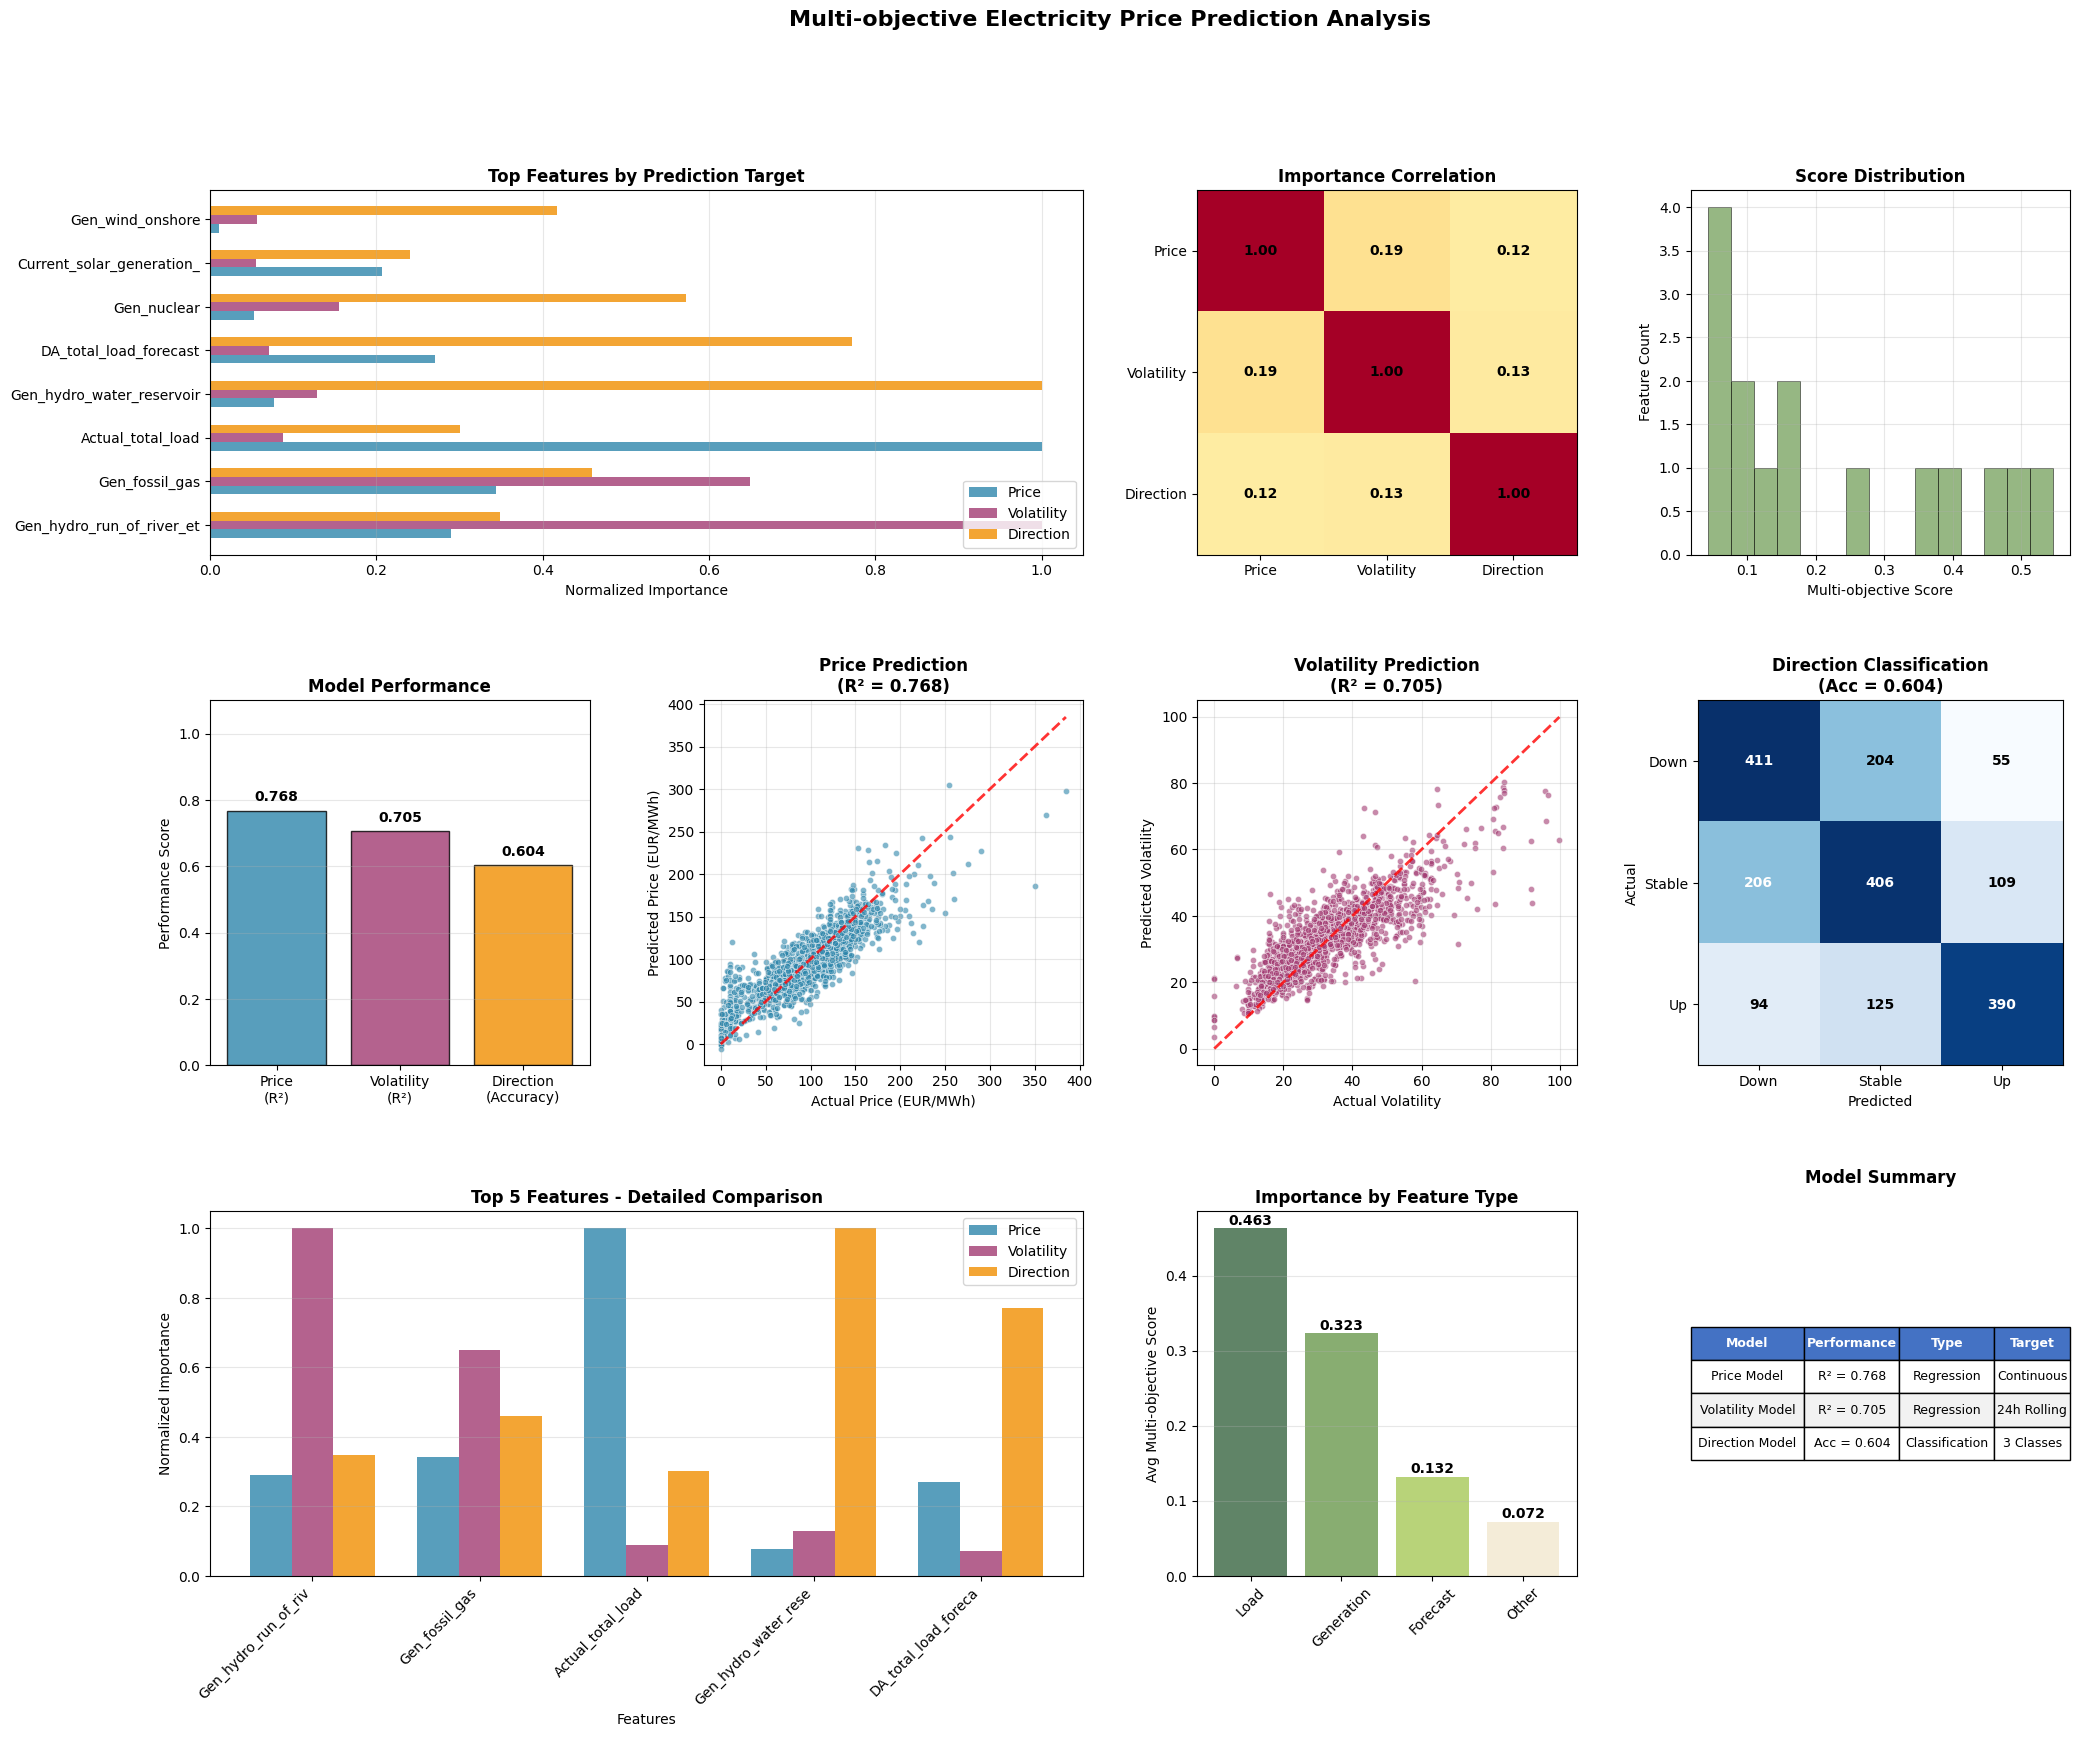


DASHBOARD SUMMARY
Best performing model: Price Model (R² = 0.768)
Most important feature: Actual_generation_MW_hydro_run_of_river_et_poundage_Romania
Average multi-objective score: 0.226
Feature correlation (Price-Volatility): 0.192


In [11]:
# ============================================================================
# CELL 7: Multi-objective Visualization Dashboard
# ============================================================================

print("Creating multi-objective visualization dashboard...")

# Set up the plotting style
plt.style.use('default')
plt.rcParams.update({'font.size': 10})

# Create main dashboard with better spacing
fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)

# ============================================================================
# ROW 1: Feature Importance Analysis
# ============================================================================

# Plot 1: Multi-objective Feature Importance Comparison (Horizontal Bar)
ax1 = fig.add_subplot(gs[0, 0:2])
top_features = importance_df.head(8)  # Reduced to 8 for better readability
y_pos = np.arange(len(top_features))

# Clean feature names
clean_names = [f.replace('_Romania', '').replace('_MW', '').replace('Actual_generation_', 'Gen_')
               .replace('Day_ahead_', 'DA_').replace('Intraday_', 'ID_')[:25] for f in top_features['Feature']]

bars1 = ax1.barh(y_pos - 0.2, top_features['Price_Importance_Normalized'],
                 height=0.2, alpha=0.8, label='Price', color='#2E86AB')
bars2 = ax1.barh(y_pos, top_features['Volatility_Importance_Normalized'],
                 height=0.2, alpha=0.8, label='Volatility', color='#A23B72')
bars3 = ax1.barh(y_pos + 0.2, top_features['Direction_Importance_Normalized'],
                 height=0.2, alpha=0.8, label='Direction', color='#F18F01')

ax1.set_yticks(y_pos)
ax1.set_yticklabels(clean_names)
ax1.set_xlabel('Normalized Importance')
ax1.set_title('Top Features by Prediction Target', fontweight='bold', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Feature Importance Correlation Heatmap
ax2 = fig.add_subplot(gs[0, 2])
corr_matrix = importance_df[['Price_Importance_Normalized', 'Volatility_Importance_Normalized',
                            'Direction_Importance_Normalized']].corr()
im = ax2.imshow(corr_matrix, cmap='RdYlBu_r', aspect='auto', vmin=-1, vmax=1)
ax2.set_xticks([0, 1, 2])
ax2.set_yticks([0, 1, 2])
ax2.set_xticklabels(['Price', 'Volatility', 'Direction'])
ax2.set_yticklabels(['Price', 'Volatility', 'Direction'])
ax2.set_title('Importance Correlation', fontweight='bold', fontsize=12)

# Add correlation values
for i in range(3):
    for j in range(3):
        ax2.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                ha='center', va='center', fontweight='bold')

# Plot 3: Multi-objective Score Distribution
ax3 = fig.add_subplot(gs[0, 3])
ax3.hist(importance_df['Multi_Objective_Score'], bins=15, alpha=0.7,
         color='#6A994E', edgecolor='black', linewidth=0.5)
ax3.set_xlabel('Multi-objective Score')
ax3.set_ylabel('Feature Count')
ax3.set_title('Score Distribution', fontweight='bold', fontsize=12)
ax3.grid(alpha=0.3)

# ============================================================================
# ROW 2: Model Performance Analysis
# ============================================================================

# Plot 4: Model Performance Comparison
ax4 = fig.add_subplot(gs[1, 0])
models = ['Price\n(R²)', 'Volatility\n(R²)', 'Direction\n(Accuracy)']
performance = [price_r2_test, vol_r2_test, dir_acc_test]
colors = ['#2E86AB', '#A23B72', '#F18F01']

bars = ax4.bar(models, performance, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax4.set_ylabel('Performance Score')
ax4.set_title('Model Performance', fontweight='bold', fontsize=12)
ax4.set_ylim(0, 1.1)
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, perf in zip(bars, performance):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{perf:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 5: Actual vs Predicted - Price
ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(y_price_test, price_pred_test, alpha=0.6, color='#2E86AB', s=20, edgecolors='white', linewidth=0.5)
min_val, max_val = y_price_test.min(), y_price_test.max()
ax5.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8)
ax5.set_xlabel('Actual Price (EUR/MWh)')
ax5.set_ylabel('Predicted Price (EUR/MWh)')
ax5.set_title(f'Price Prediction\n(R² = {price_r2_test:.3f})', fontweight='bold', fontsize=12)
ax5.grid(alpha=0.3)

# Plot 6: Actual vs Predicted - Volatility
ax6 = fig.add_subplot(gs[1, 2])
ax6.scatter(y_vol_test, vol_pred_test, alpha=0.6, color='#A23B72', s=20, edgecolors='white', linewidth=0.5)
min_val, max_val = y_vol_test.min(), y_vol_test.max()
ax6.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8)
ax6.set_xlabel('Actual Volatility')
ax6.set_ylabel('Predicted Volatility')
ax6.set_title(f'Volatility Prediction\n(R² = {vol_r2_test:.3f})', fontweight='bold', fontsize=12)
ax6.grid(alpha=0.3)

# Plot 7: Direction Classification Confusion Matrix (if available)
ax7 = fig.add_subplot(gs[1, 3])
try:
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_dir_test, dir_pred_test)
    labels = ['Down', 'Stable', 'Up']

    im = ax7.imshow(cm, interpolation='nearest', cmap='Blues')
    ax7.set_title(f'Direction Classification\n(Acc = {dir_acc_test:.3f})', fontweight='bold', fontsize=12)

    # Add labels
    tick_marks = np.arange(len(labels))
    ax7.set_xticks(tick_marks)
    ax7.set_yticks(tick_marks)
    ax7.set_xticklabels(labels)
    ax7.set_yticklabels(labels)
    ax7.set_xlabel('Predicted')
    ax7.set_ylabel('Actual')

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        ax7.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > thresh else "black")

except:
    # Fallback if confusion matrix can't be created
    ax7.text(0.5, 0.5, f'Direction Accuracy\n{dir_acc_test:.3f}',
             ha='center', va='center', transform=ax7.transAxes,
             fontsize=16, fontweight='bold')
    ax7.set_title('Direction Performance', fontweight='bold', fontsize=12)

# ============================================================================
# ROW 3: Detailed Feature Analysis
# ============================================================================

# Plot 8: Top 5 Features Detailed Comparison
ax8 = fig.add_subplot(gs[2, 0:2])
top_5_features = importance_df.head(5)
x_pos = np.arange(len(top_5_features))
width = 0.25

clean_names_5 = [f.replace('_Romania', '').replace('_MW', '').replace('Actual_generation_', 'Gen_')
                 .replace('Day_ahead_', 'DA_').replace('Intraday_', 'ID_')[:20]
                 for f in top_5_features['Feature']]

bars1 = ax8.bar(x_pos - width, top_5_features['Price_Importance_Normalized'],
                width, label='Price', alpha=0.8, color='#2E86AB')
bars2 = ax8.bar(x_pos, top_5_features['Volatility_Importance_Normalized'],
                width, label='Volatility', alpha=0.8, color='#A23B72')
bars3 = ax8.bar(x_pos + width, top_5_features['Direction_Importance_Normalized'],
                width, label='Direction', alpha=0.8, color='#F18F01')

ax8.set_xlabel('Features')
ax8.set_ylabel('Normalized Importance')
ax8.set_title('Top 5 Features - Detailed Comparison', fontweight='bold', fontsize=12)
ax8.set_xticks(x_pos)
ax8.set_xticklabels(clean_names_5, rotation=45, ha='right')
ax8.legend()
ax8.grid(axis='y', alpha=0.3)

# Plot 9: Feature Type Analysis
ax9 = fig.add_subplot(gs[2, 2])
# Categorize features by type
feature_types = []
for feature in importance_df['Feature']:
    if 'forecast' in feature.lower():
        feature_types.append('Forecast')
    elif 'actual_generation' in feature.lower():
        feature_types.append('Generation')
    elif 'actual_total_load' in feature.lower():
        feature_types.append('Load')
    else:
        feature_types.append('Other')

importance_df['Feature_Type'] = feature_types
type_importance = importance_df.groupby('Feature_Type')['Multi_Objective_Score'].mean().sort_values(ascending=False)

bars = ax9.bar(type_importance.index, type_importance.values,
               color=['#386641', '#6A994E', '#A7C957', '#F2E8CF'], alpha=0.8)
ax9.set_ylabel('Avg Multi-objective Score')
ax9.set_title('Importance by Feature Type', fontweight='bold', fontsize=12)
ax9.tick_params(axis='x', rotation=45)
ax9.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, type_importance.values):
    ax9.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 10: Model Comparison Summary
ax10 = fig.add_subplot(gs[2, 3])
summary_data = {
    'Price Model': [f'R² = {price_r2_test:.3f}', 'Regression', 'Continuous'],
    'Volatility Model': [f'R² = {vol_r2_test:.3f}', 'Regression', '24h Rolling'],
    'Direction Model': [f'Acc = {dir_acc_test:.3f}', 'Classification', '3 Classes']
}

ax10.axis('off')
table_data = []
for model, metrics in summary_data.items():
    table_data.append([model] + metrics)

table = ax10.table(cellText=table_data,
                   colLabels=['Model', 'Performance', 'Type', 'Target'],
                   cellLoc='center',
                   loc='center',
                   colWidths=[0.3, 0.25, 0.25, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style the table
for i in range(len(table_data) + 1):
    for j in range(4):
        cell = table[i, j]
        if i == 0:  # Header
            cell.set_facecolor('#4472C4')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#F2F2F2' if i % 2 == 0 else 'white')

ax10.set_title('Model Summary', fontweight='bold', fontsize=12, pad=20)

# Add main title
fig.suptitle('Multi-objective Electricity Price Prediction Analysis',
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("DASHBOARD SUMMARY")
print("="*60)
print(f"Best performing model: Price Model (R² = {price_r2_test:.3f})")
print(f"Most important feature: {importance_df.iloc[0]['Feature']}")
print(f"Average multi-objective score: {importance_df['Multi_Objective_Score'].mean():.3f}")
print(f"Feature correlation (Price-Volatility): {corr_matrix.iloc[0,1]:.3f}")
print("="*60)

Creating individual downloadable visualizations...


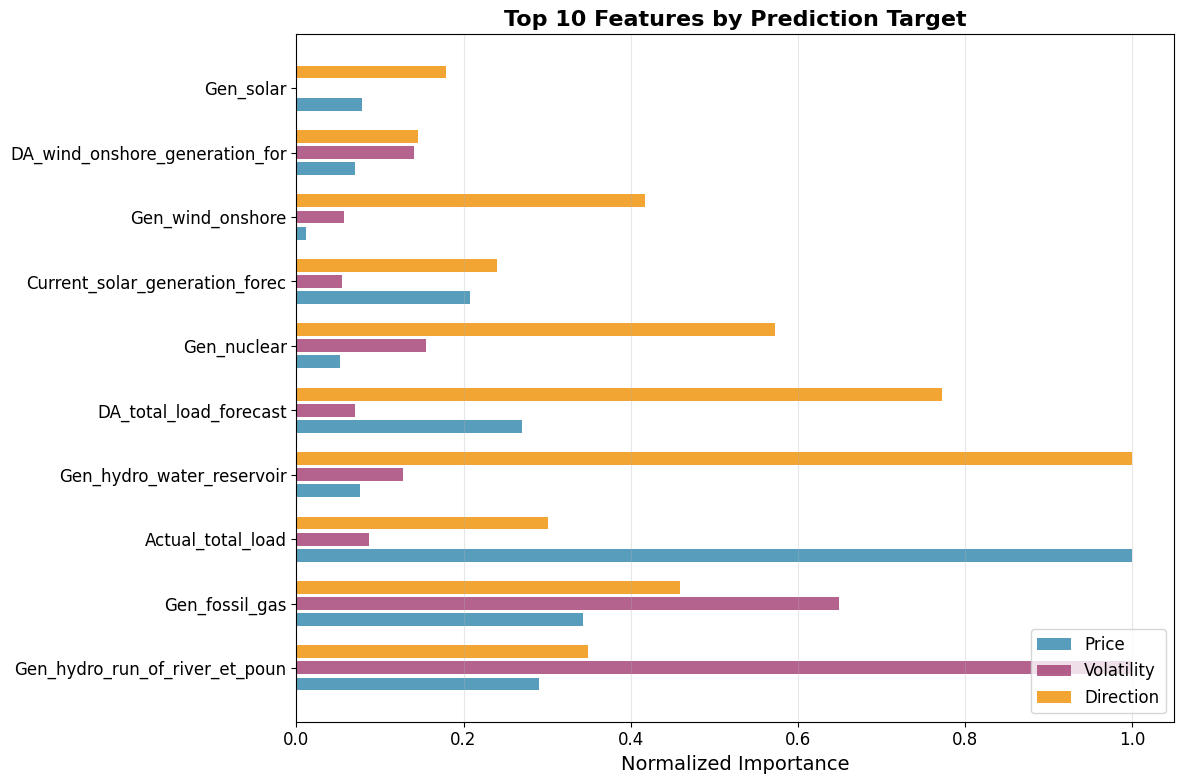

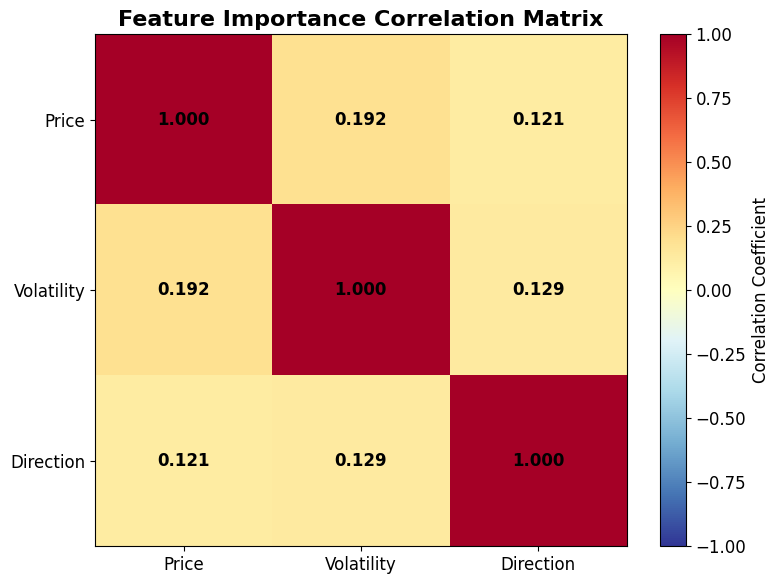

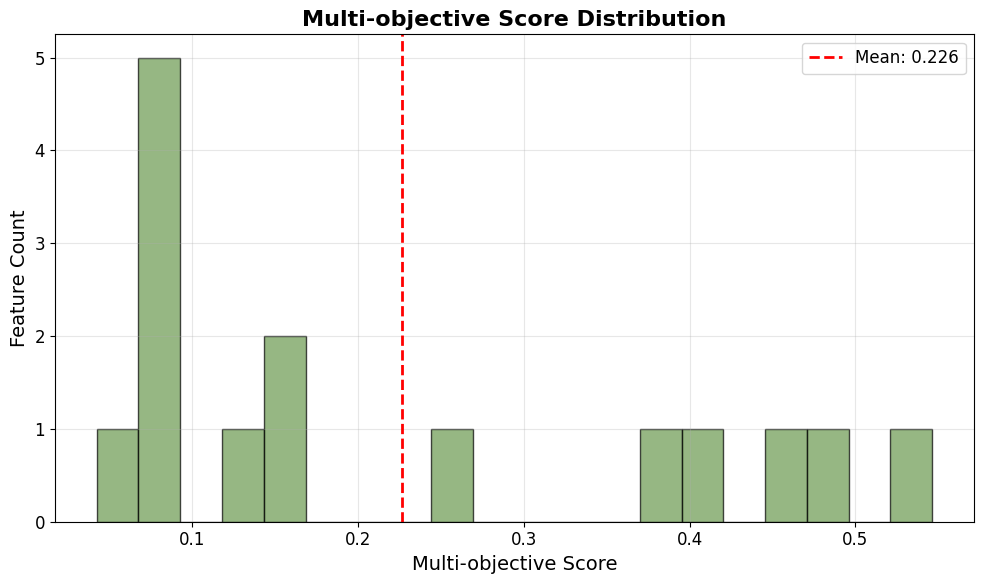

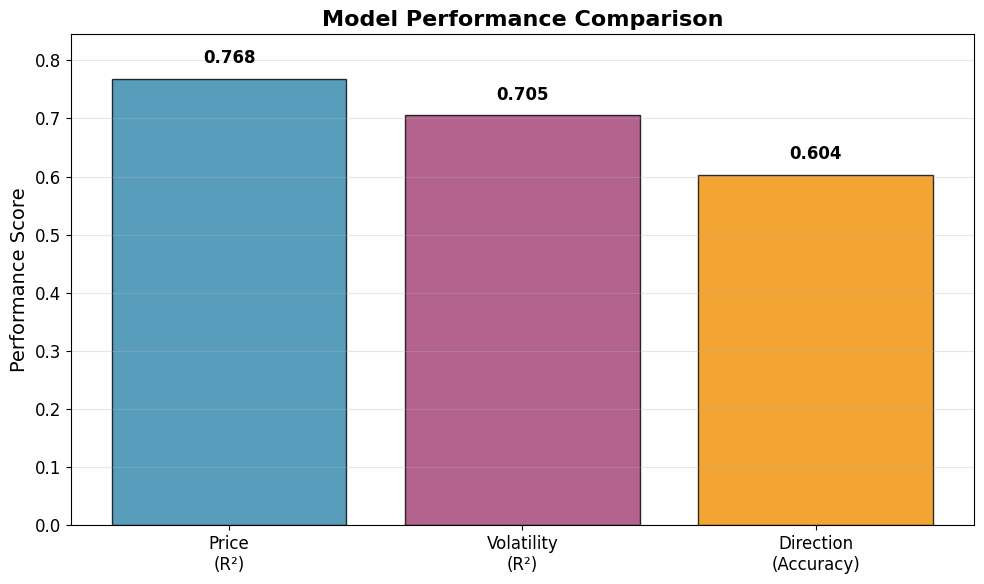

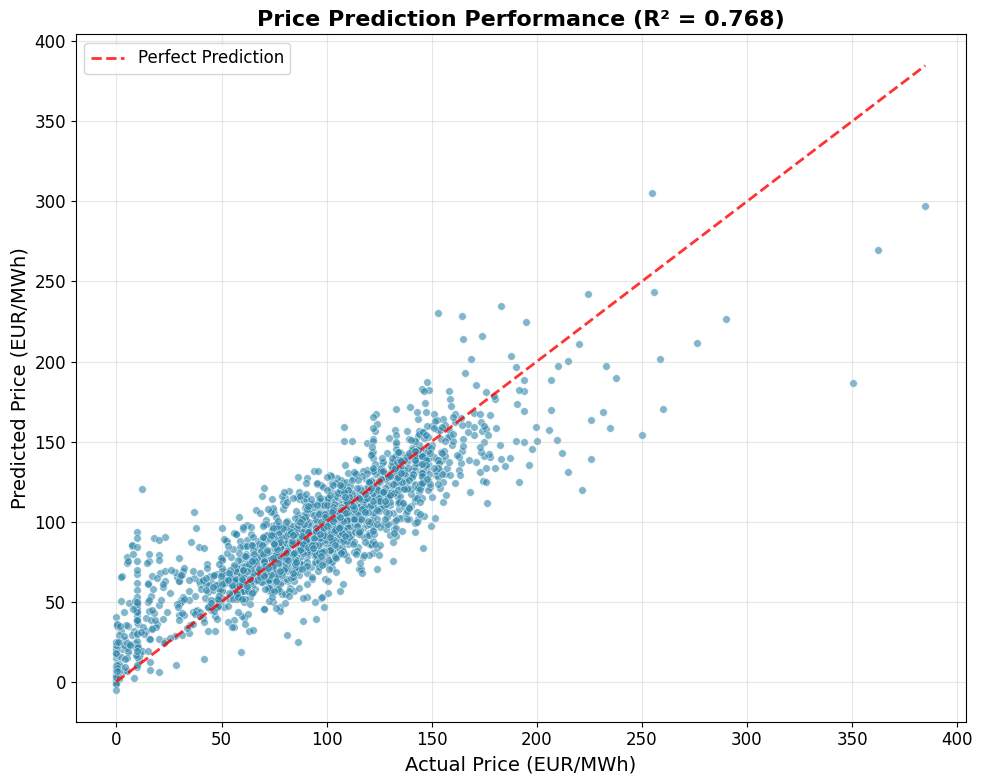

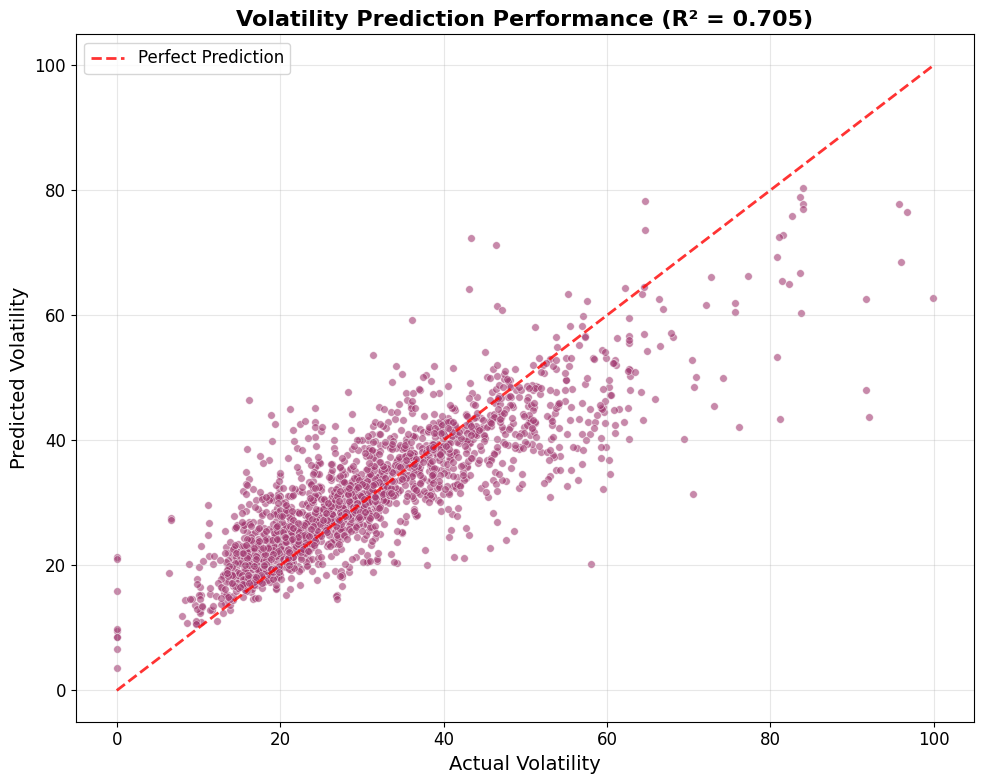

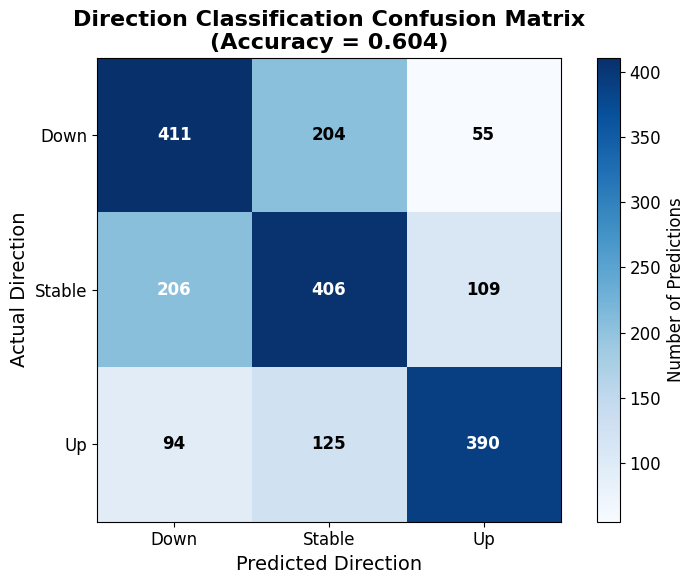

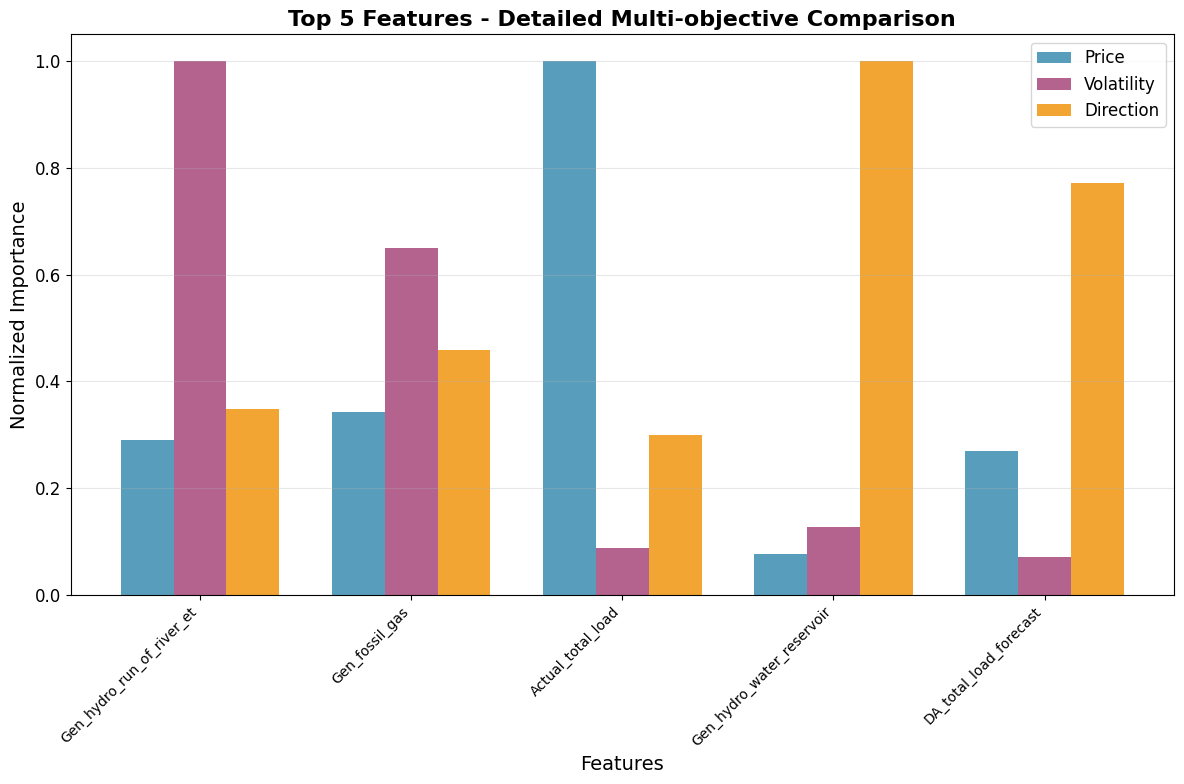

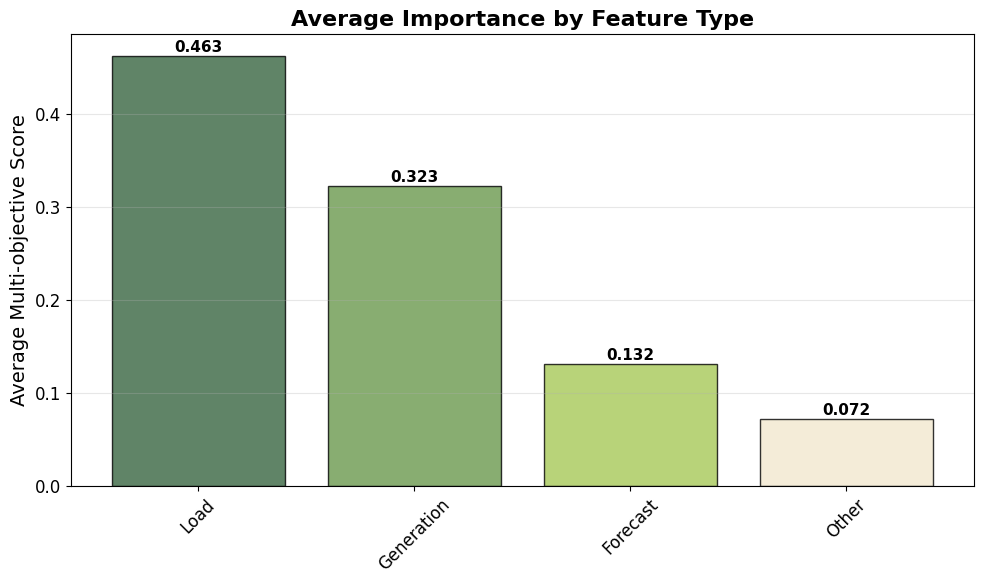

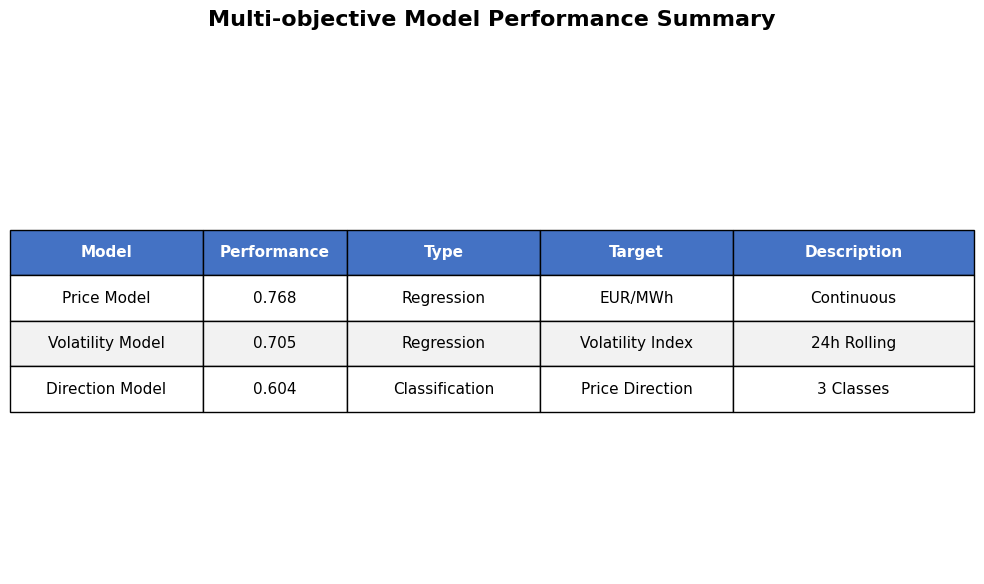


INDIVIDUAL VISUALIZATIONS CREATED SUCCESSFULLY
📊 Total visualizations created: 10
📁 Saved to directory: visualization_outputs/
📈 Best performing model: Price Model (R² = 0.768)
🎯 Most important feature: Actual_generation_MW_hydro_run_of_river_et_poundage_Romania
⚖️ Average multi-objective score: 0.226
🔗 Feature correlation (Price-Volatility): 0.192
All visualizations are now saved as high-resolution PNG files!
You can download them individually from your notebook environment.


In [12]:
# ============================================================================
# CELL 7 bis: Individual Multi-objective Visualizations (Downloadable)
# ============================================================================

print("Creating individual downloadable visualizations...")

# Set up the plotting style
plt.style.use('default')
plt.rcParams.update({'font.size': 12})

# Create output directory for saving plots (optional)
import os
output_dir = 'visualization_outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ============================================================================
# VISUALIZATION 1: Multi-objective Feature Importance Comparison
# ============================================================================

fig1, ax1 = plt.subplots(figsize=(12, 8))
top_features = importance_df.head(10)
y_pos = np.arange(len(top_features))

# Clean feature names
clean_names = [f.replace('_Romania', '').replace('_MW', '').replace('Actual_generation_', 'Gen_')
               .replace('Day_ahead_', 'DA_').replace('Intraday_', 'ID_')[:30] for f in top_features['Feature']]

bars1 = ax1.barh(y_pos - 0.25, top_features['Price_Importance_Normalized'],
                 height=0.2, alpha=0.8, label='Price', color='#2E86AB')
bars2 = ax1.barh(y_pos, top_features['Volatility_Importance_Normalized'],
                 height=0.2, alpha=0.8, label='Volatility', color='#A23B72')
bars3 = ax1.barh(y_pos + 0.25, top_features['Direction_Importance_Normalized'],
                 height=0.2, alpha=0.8, label='Direction', color='#F18F01')

ax1.set_yticks(y_pos)
ax1.set_yticklabels(clean_names)
ax1.set_xlabel('Normalized Importance', fontsize=14)
ax1.set_title('Top 10 Features by Prediction Target', fontweight='bold', fontsize=16)
ax1.legend(loc='lower right', fontsize=12)
ax1.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VISUALIZATION 2: Feature Importance Correlation Heatmap
# ============================================================================

fig2, ax2 = plt.subplots(figsize=(8, 6))
corr_matrix = importance_df[['Price_Importance_Normalized', 'Volatility_Importance_Normalized',
                            'Direction_Importance_Normalized']].corr()

im = ax2.imshow(corr_matrix, cmap='RdYlBu_r', aspect='auto', vmin=-1, vmax=1)
ax2.set_xticks([0, 1, 2])
ax2.set_yticks([0, 1, 2])
ax2.set_xticklabels(['Price', 'Volatility', 'Direction'], fontsize=12)
ax2.set_yticklabels(['Price', 'Volatility', 'Direction'], fontsize=12)
ax2.set_title('Feature Importance Correlation Matrix', fontweight='bold', fontsize=16)

# Add correlation values
for i in range(3):
    for j in range(3):
        ax2.text(j, i, f'{corr_matrix.iloc[i, j]:.3f}',
                ha='center', va='center', fontweight='bold', fontsize=12)

# Add colorbar
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Correlation Coefficient', fontsize=12)

plt.tight_layout()
plt.savefig(f'{output_dir}/importance_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VISUALIZATION 3: Multi-objective Score Distribution
# ============================================================================

fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.hist(importance_df['Multi_Objective_Score'], bins=20, alpha=0.7,
         color='#6A994E', edgecolor='black', linewidth=1)
ax3.axvline(importance_df['Multi_Objective_Score'].mean(), color='red',
           linestyle='--', linewidth=2, label=f'Mean: {importance_df["Multi_Objective_Score"].mean():.3f}')
ax3.set_xlabel('Multi-objective Score', fontsize=14)
ax3.set_ylabel('Feature Count', fontsize=14)
ax3.set_title('Multi-objective Score Distribution', fontweight='bold', fontsize=16)
ax3.legend(fontsize=12)
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VISUALIZATION 4: Model Performance Comparison
# ============================================================================

fig4, ax4 = plt.subplots(figsize=(10, 6))
models = ['Price\n(R²)', 'Volatility\n(R²)', 'Direction\n(Accuracy)']
performance = [price_r2_test, vol_r2_test, dir_acc_test]
colors = ['#2E86AB', '#A23B72', '#F18F01']

bars = ax4.bar(models, performance, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax4.set_ylabel('Performance Score', fontsize=14)
ax4.set_title('Model Performance Comparison', fontweight='bold', fontsize=16)
ax4.set_ylim(0, max(performance) * 1.1)
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, perf in zip(bars, performance):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{perf:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(f'{output_dir}/model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VISUALIZATION 5: Actual vs Predicted - Price Model
# ============================================================================

fig5, ax5 = plt.subplots(figsize=(10, 8))
ax5.scatter(y_price_test, price_pred_test, alpha=0.6, color='#2E86AB', s=30, edgecolors='white', linewidth=0.5)
min_val, max_val = y_price_test.min(), y_price_test.max()
ax5.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8, label='Perfect Prediction')
ax5.set_xlabel('Actual Price (EUR/MWh)', fontsize=14)
ax5.set_ylabel('Predicted Price (EUR/MWh)', fontsize=14)
ax5.set_title(f'Price Prediction Performance (R² = {price_r2_test:.3f})', fontweight='bold', fontsize=16)
ax5.legend(fontsize=12)
ax5.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/price_prediction_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VISUALIZATION 6: Actual vs Predicted - Volatility Model
# ============================================================================

fig6, ax6 = plt.subplots(figsize=(10, 8))
ax6.scatter(y_vol_test, vol_pred_test, alpha=0.6, color='#A23B72', s=30, edgecolors='white', linewidth=0.5)
min_val, max_val = y_vol_test.min(), y_vol_test.max()
ax6.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8, label='Perfect Prediction')
ax6.set_xlabel('Actual Volatility', fontsize=14)
ax6.set_ylabel('Predicted Volatility', fontsize=14)
ax6.set_title(f'Volatility Prediction Performance (R² = {vol_r2_test:.3f})', fontweight='bold', fontsize=16)
ax6.legend(fontsize=12)
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/volatility_prediction_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VISUALIZATION 7: Direction Classification Confusion Matrix
# ============================================================================

fig7, ax7 = plt.subplots(figsize=(8, 6))
try:
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_dir_test, dir_pred_test)
    labels = ['Down', 'Stable', 'Up']

    im = ax7.imshow(cm, interpolation='nearest', cmap='Blues')
    ax7.set_title(f'Direction Classification Confusion Matrix\n(Accuracy = {dir_acc_test:.3f})',
                 fontweight='bold', fontsize=16)

    # Add labels
    tick_marks = np.arange(len(labels))
    ax7.set_xticks(tick_marks)
    ax7.set_yticks(tick_marks)
    ax7.set_xticklabels(labels, fontsize=12)
    ax7.set_yticklabels(labels, fontsize=12)
    ax7.set_xlabel('Predicted Direction', fontsize=14)
    ax7.set_ylabel('Actual Direction', fontsize=14)

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        ax7.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold', fontsize=12,
                color="white" if cm[i, j] > thresh else "black")

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax7)
    cbar.set_label('Number of Predictions', fontsize=12)

except:
    # Fallback if confusion matrix can't be created
    ax7.text(0.5, 0.5, f'Direction Classification\nAccuracy: {dir_acc_test:.3f}',
             ha='center', va='center', transform=ax7.transAxes,
             fontsize=20, fontweight='bold')
    ax7.set_title('Direction Classification Performance', fontweight='bold', fontsize=16)

plt.tight_layout()
plt.savefig(f'{output_dir}/direction_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VISUALIZATION 8: Top 5 Features Detailed Comparison
# ============================================================================

fig8, ax8 = plt.subplots(figsize=(12, 8))
top_5_features = importance_df.head(5)
x_pos = np.arange(len(top_5_features))
width = 0.25

clean_names_5 = [f.replace('_Romania', '').replace('_MW', '').replace('Actual_generation_', 'Gen_')
                 .replace('Day_ahead_', 'DA_').replace('Intraday_', 'ID_')[:25]
                 for f in top_5_features['Feature']]

bars1 = ax8.bar(x_pos - width, top_5_features['Price_Importance_Normalized'],
                width, label='Price', alpha=0.8, color='#2E86AB')
bars2 = ax8.bar(x_pos, top_5_features['Volatility_Importance_Normalized'],
                width, label='Volatility', alpha=0.8, color='#A23B72')
bars3 = ax8.bar(x_pos + width, top_5_features['Direction_Importance_Normalized'],
                width, label='Direction', alpha=0.8, color='#F18F01')

ax8.set_xlabel('Features', fontsize=14)
ax8.set_ylabel('Normalized Importance', fontsize=14)
ax8.set_title('Top 5 Features - Detailed Multi-objective Comparison', fontweight='bold', fontsize=16)
ax8.set_xticks(x_pos)
ax8.set_xticklabels(clean_names_5, rotation=45, ha='right', fontsize=10)
ax8.legend(fontsize=12)
ax8.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/top5_features_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VISUALIZATION 9: Feature Type Analysis
# ============================================================================

fig9, ax9 = plt.subplots(figsize=(10, 6))
# Categorize features by type
feature_types = []
for feature in importance_df['Feature']:
    if 'forecast' in feature.lower():
        feature_types.append('Forecast')
    elif 'actual_generation' in feature.lower():
        feature_types.append('Generation')
    elif 'actual_total_load' in feature.lower():
        feature_types.append('Load')
    else:
        feature_types.append('Other')

importance_df['Feature_Type'] = feature_types
type_importance = importance_df.groupby('Feature_Type')['Multi_Objective_Score'].mean().sort_values(ascending=False)

bars = ax9.bar(type_importance.index, type_importance.values,
               color=['#386641', '#6A994E', '#A7C957', '#F2E8CF'], alpha=0.8, edgecolor='black', linewidth=1)
ax9.set_ylabel('Average Multi-objective Score', fontsize=14)
ax9.set_title('Average Importance by Feature Type', fontweight='bold', fontsize=16)
ax9.tick_params(axis='x', rotation=45, labelsize=12)
ax9.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, type_importance.values):
    ax9.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(f'{output_dir}/feature_type_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# VISUALIZATION 10: Model Summary Table
# ============================================================================

fig10, ax10 = plt.subplots(figsize=(10, 6))
summary_data = {
    'Price Model': [f'{price_r2_test:.3f}', 'Regression', 'EUR/MWh', 'Continuous'],
    'Volatility Model': [f'{vol_r2_test:.3f}', 'Regression', 'Volatility Index', '24h Rolling'],
    'Direction Model': [f'{dir_acc_test:.3f}', 'Classification', 'Price Direction', '3 Classes']
}

ax10.axis('off')
table_data = []
for model, metrics in summary_data.items():
    table_data.append([model] + metrics)

table = ax10.table(cellText=table_data,
                   colLabels=['Model', 'Performance', 'Type', 'Target', 'Description'],
                   cellLoc='center',
                   loc='center',
                   colWidths=[0.2, 0.15, 0.2, 0.2, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style the table
for i in range(len(table_data) + 1):
    for j in range(5):
        cell = table[i, j]
        if i == 0:  # Header
            cell.set_facecolor('#4472C4')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#F2F2F2' if i % 2 == 0 else 'white')

ax10.set_title('Multi-objective Model Performance Summary', fontweight='bold', fontsize=16, pad=30)

plt.tight_layout()
plt.savefig(f'{output_dir}/model_summary_table.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*70)
print("INDIVIDUAL VISUALIZATIONS CREATED SUCCESSFULLY")
print("="*70)
print(f"📊 Total visualizations created: 10")
print(f"📁 Saved to directory: {output_dir}/")
print(f"📈 Best performing model: Price Model (R² = {price_r2_test:.3f})")
print(f"🎯 Most important feature: {importance_df.iloc[0]['Feature']}")
print(f"⚖️ Average multi-objective score: {importance_df['Multi_Objective_Score'].mean():.3f}")
print(f"🔗 Feature correlation (Price-Volatility): {corr_matrix.iloc[0,1]:.3f}")
print("="*70)
print("All visualizations are now saved as high-resolution PNG files!")
print("You can download them individually from your notebook environment.")
print("="*70)

In [13]:
# ============================================================================
# CELL 7 ter: Comprehensive Dashboard Analysis - Text Report
# ============================================================================

print("=" * 80)
print("COMPREHENSIVE MULTI-OBJECTIVE DASHBOARD ANALYSIS REPORT")
print("=" * 80)

# ============================================================================
# SECTION 1: FEATURE IMPORTANCE COMPREHENSIVE ANALYSIS
# ============================================================================

print("\n1. FEATURE IMPORTANCE DEEP DIVE ANALYSIS:")
print("-" * 50)

# Recreate the top features analysis from the dashboard
top_features = importance_df.head(8)
clean_names = [f.replace('_Romania', '').replace('_MW', '').replace('Actual_generation_', 'Gen_')
               .replace('Day_ahead_', 'DA_').replace('Intraday_', 'ID_')[:25] for f in top_features['Feature']]

print("Top 8 Features Detailed Analysis:")
print("(Based on horizontal bar chart visualization)\n")

for i, (idx, row) in enumerate(top_features.iterrows(), 1):
    feature_name = row['Feature']
    clean_name = clean_names[i-1]

    print(f"#{i} {clean_name}")
    print(f"    Full Name: {feature_name}")
    print(f"    Price Importance:     {row['Price_Importance_Normalized']:.4f}")
    print(f"    Volatility Importance: {row['Volatility_Importance_Normalized']:.4f}")
    print(f"    Direction Importance:  {row['Direction_Importance_Normalized']:.4f}")
    print(f"    Multi-Objective Score: {row['Multi_Objective_Score']:.4f}")

    # Determine the strongest objective for this feature
    obj_scores = [row['Price_Importance_Normalized'],
                  row['Volatility_Importance_Normalized'],
                  row['Direction_Importance_Normalized']]
    obj_names = ['Price', 'Volatility', 'Direction']
    strongest_obj = obj_names[np.argmax(obj_scores)]
    strongest_score = max(obj_scores)

    print(f"    Strongest Objective: {strongest_obj} ({strongest_score:.4f})")

    # Feature type classification
    if 'hydro' in feature_name.lower():
        feature_type = "Hydro Generation"
    elif 'fossil_gas' in feature_name.lower():
        feature_type = "Fossil Gas Generation"
    elif 'load' in feature_name.lower():
        feature_type = "Electricity Load"
    elif 'nuclear' in feature_name.lower():
        feature_type = "Nuclear Generation"
    elif 'solar' in feature_name.lower():
        feature_type = "Solar Generation"
    elif 'wind' in feature_name.lower():
        feature_type = "Wind Generation"
    else:
        feature_type = "Other"

    print(f"    Feature Category: {feature_type}")
    print()

# ============================================================================
# SECTION 2: CORRELATION ANALYSIS
# ============================================================================

print("\n2. OBJECTIVE CORRELATION ANALYSIS:")
print("-" * 50)

# Calculate correlation matrix
corr_matrix = importance_df[['Price_Importance_Normalized', 'Volatility_Importance_Normalized',
                            'Direction_Importance_Normalized']].corr()

print("Feature Importance Correlation Matrix:")
print("(Values range from -1 to +1, where +1 = perfect positive correlation)")
print()

correlations = [
    ('Price vs Volatility', corr_matrix.iloc[0,1]),
    ('Price vs Direction', corr_matrix.iloc[0,2]),
    ('Volatility vs Direction', corr_matrix.iloc[1,2])
]

for pair, corr_value in correlations:
    print(f"{pair:20s}: {corr_value:7.4f}", end="")

    if corr_value > 0.7:
        interpretation = "(Strong Positive - Features important for both)"
    elif corr_value > 0.3:
        interpretation = "(Moderate Positive - Some shared importance)"
    elif corr_value > -0.3:
        interpretation = "(Weak - Different important features)"
    elif corr_value > -0.7:
        interpretation = "(Moderate Negative - Opposing importance)"
    else:
        interpretation = "(Strong Negative - Highly opposing importance)"

    print(f" {interpretation}")

print(f"\nCorrelation Insights:")
avg_correlation = np.mean([abs(corr) for _, corr in correlations])
print(f"• Average absolute correlation: {avg_correlation:.4f}")

if avg_correlation > 0.6:
    print("• HIGH correlation suggests features important for one objective tend to be important for others")
    print("• Multi-objective approach may be redundant - consider single unified model")
elif avg_correlation < 0.3:
    print("• LOW correlation suggests different features drive different objectives")
    print("• Multi-objective approach is well-justified - each objective needs different features")
else:
    print("• MODERATE correlation suggests partial overlap in feature importance")
    print("• Multi-objective approach provides value while sharing some common drivers")

# ============================================================================
# SECTION 3: MODEL PERFORMANCE COMPREHENSIVE ANALYSIS
# ============================================================================

print("\n\n3. MODEL PERFORMANCE COMPREHENSIVE ANALYSIS:")
print("-" * 50)

# Performance metrics
performance_data = [
    ('Price Model (R²)', price_r2_test, 'Regression'),
    ('Volatility Model (R²)', vol_r2_test, 'Regression'),
    ('Direction Model (Accuracy)', dir_acc_test, 'Classification')
]

print("Individual Model Performance:")
for model_name, score, model_type in performance_data:
    print(f"\n{model_name}:")
    print(f"  Score: {score:.4f}")
    print(f"  Type: {model_type}")

    if model_type == 'Regression':
        if score > 0.9:
            performance_level = "Excellent"
        elif score > 0.8:
            performance_level = "Very Good"
        elif score > 0.7:
            performance_level = "Good"
        elif score > 0.6:
            performance_level = "Moderate"
        else:
            performance_level = "Poor"
        print(f"  Performance Level: {performance_level}")
        print(f"  Interpretation: Model explains {score*100:.1f}% of variance in target variable")
    else:  # Classification
        if score > 0.9:
            performance_level = "Excellent"
        elif score > 0.8:
            performance_level = "Very Good"
        elif score > 0.7:
            performance_level = "Good"
        elif score > 0.6:
            performance_level = "Moderate"
        else:
            performance_level = "Poor"
        print(f"  Performance Level: {performance_level}")
        print(f"  Interpretation: Model correctly classifies {score*100:.1f}% of price directions")

# Overall performance analysis
avg_performance = np.mean([price_r2_test, vol_r2_test, dir_acc_test])
best_model = max(performance_data, key=lambda x: x[1])
worst_model = min(performance_data, key=lambda x: x[1])

print(f"\nOverall Performance Summary:")
print(f"• Average Performance: {avg_performance:.4f}")
print(f"• Best Performing Model: {best_model[0]} ({best_model[1]:.4f})")
print(f"• Weakest Performing Model: {worst_model[0]} ({worst_model[1]:.4f})")
print(f"• Performance Range: {best_model[1] - worst_model[1]:.4f}")

if best_model[1] - worst_model[1] > 0.2:
    print("• HIGH performance variance - some objectives much easier to predict than others")
elif best_model[1] - worst_model[1] < 0.1:
    print("• LOW performance variance - all objectives similarly predictable")
else:
    print("• MODERATE performance variance - some differences in predictability")

# ============================================================================
# SECTION 4: FEATURE TYPE ANALYSIS
# ============================================================================

print("\n\n4. FEATURE TYPE COMPREHENSIVE ANALYSIS:")
print("-" * 50)

# Recreate feature type analysis
feature_types = []
for feature in importance_df['Feature']:
    if 'forecast' in feature.lower():
        feature_types.append('Forecast')
    elif 'actual_generation' in feature.lower():
        feature_types.append('Generation')
    elif 'actual_total_load' in feature.lower():
        feature_types.append('Load')
    else:
        feature_types.append('Other')

importance_df_temp = importance_df.copy()
importance_df_temp['Feature_Type'] = feature_types
type_importance = importance_df_temp.groupby('Feature_Type')['Multi_Objective_Score'].mean().sort_values(ascending=False)
type_counts = importance_df_temp['Feature_Type'].value_counts()

print("Feature Type Importance Analysis:")
print("(Average multi-objective importance score by feature category)\n")

for feature_type in type_importance.index:
    avg_importance = type_importance[feature_type]
    count = type_counts[feature_type]
    features_of_type = importance_df_temp[importance_df_temp['Feature_Type'] == feature_type]['Feature'].tolist()

    print(f"{feature_type} Features:")
    print(f"  Average Importance: {avg_importance:.4f}")
    print(f"  Number of Features: {count}")
    print(f"  Features in Category:")

    for feature in features_of_type:
        score = importance_df_temp[importance_df_temp['Feature'] == feature]['Multi_Objective_Score'].iloc[0]
        short_name = feature.replace('_Romania', '').replace('_MW', '')[:40]
        print(f"    • {short_name:<40} ({score:.4f})")
    print()

# Feature type insights
print("Feature Type Insights:")
most_important_type = type_importance.index[0]
least_important_type = type_importance.index[-1]
print(f"• Most Important Feature Type: {most_important_type} (avg: {type_importance[most_important_type]:.4f})")
print(f"• Least Important Feature Type: {least_important_type} (avg: {type_importance[least_important_type]:.4f})")

if 'Generation' in type_importance.index and type_importance['Generation'] > 0.3:
    print("• Actual generation data shows high importance - real-time generation strongly influences prices")
if 'Forecast' in type_importance.index and type_importance['Forecast'] > 0.2:
    print("• Forecast data shows significant importance - forward-looking information adds predictive value")
if 'Load' in type_importance.index and type_importance['Load'] > 0.3:
    print("• Load data shows high importance - electricity demand is a key price driver")

# ============================================================================
# SECTION 5: DISTRIBUTION ANALYSIS
# ============================================================================

print("\n\n5. FEATURE IMPORTANCE DISTRIBUTION ANALYSIS:")
print("-" * 50)

# Statistical analysis of the multi-objective score distribution
scores = importance_df['Multi_Objective_Score']
print("Multi-objective Score Distribution Statistics:")
print(f"• Mean:           {scores.mean():.4f}")
print(f"• Median:         {scores.median():.4f}")
print(f"• Standard Dev:   {scores.std():.4f}")
print(f"• Minimum:        {scores.min():.4f}")
print(f"• Maximum:        {scores.max():.4f}")
print(f"• Range:          {scores.max() - scores.min():.4f}")
print(f"• 25th Percentile: {scores.quantile(0.25):.4f}")
print(f"• 75th Percentile: {scores.quantile(0.75):.4f}")

# Distribution shape analysis
skewness = scores.skew() if hasattr(scores, 'skew') else 'N/A'
print(f"• Skewness:       {skewness}")

if isinstance(skewness, (int, float)):
    if skewness > 1:
        distribution_shape = "Highly right-skewed (few very important features)"
    elif skewness > 0.5:
        distribution_shape = "Moderately right-skewed (some dominant features)"
    elif skewness > -0.5:
        distribution_shape = "Approximately symmetric (balanced importance)"
    elif skewness > -1:
        distribution_shape = "Moderately left-skewed (most features important)"
    else:
        distribution_shape = "Highly left-skewed (uniform high importance)"

    print(f"• Distribution Shape: {distribution_shape}")

# Feature importance tiers
high_importance = len(scores[scores > scores.quantile(0.75)])
medium_importance = len(scores[(scores >= scores.quantile(0.25)) & (scores <= scores.quantile(0.75))])
low_importance = len(scores[scores < scores.quantile(0.25)])

print(f"\nFeature Importance Tiers:")
print(f"• High Importance (>75th percentile):     {high_importance} features")
print(f"• Medium Importance (25th-75th percentile): {medium_importance} features")
print(f"• Low Importance (<25th percentile):      {low_importance} features")

# ============================================================================
# SECTION 6: ACTIONABLE INSIGHTS AND RECOMMENDATIONS
# ============================================================================

print("\n\n6. ACTIONABLE INSIGHTS AND RECOMMENDATIONS:")
print("-" * 50)

print("Key Findings:")

# 1. Feature selection recommendations
top_threshold = scores.quantile(0.8)
recommended_features = len(scores[scores >= top_threshold])
print(f"• Feature Selection: Consider using top {recommended_features} features (80th percentile threshold: {top_threshold:.4f})")

# 2. Model-specific insights
if price_r2_test > max(vol_r2_test, dir_acc_test):
    print(f"• Price prediction shows strongest performance - consider this as primary objective")
elif vol_r2_test > max(price_r2_test, dir_acc_test):
    print(f"• Volatility prediction shows strongest performance - focus on this objective")
else:
    print(f"• Direction classification shows strongest performance - categorical approach may be optimal")

# 3. Feature type recommendations
if 'Generation' in type_importance.index and type_importance['Generation'] > type_importance.mean():
    print(f"• Prioritize real-time generation data collection - shows above-average importance")
if 'Forecast' in type_importance.index and type_importance['Forecast'] > type_importance.mean():
    print(f"• Forecast data adds significant value - maintain/improve forecasting systems")

# 4. Multi-objective strategy
if avg_correlation > 0.6:
    print(f"• Consider unified modeling approach - high correlation suggests shared feature drivers")
else:
    print(f"• Multi-objective approach is optimal - different objectives require different features")

# 5. Data collection priorities
top_feature = importance_df.iloc[0]['Feature']
if 'hydro' in top_feature.lower():
    print(f"• Hydro generation data is critical - ensure high-quality, real-time collection")
elif 'gas' in top_feature.lower():
    print(f"• Gas generation data is critical - monitor fuel costs and availability")
elif 'load' in top_feature.lower():
    print(f"• Load forecasting is critical - invest in demand prediction capabilities")

print(f"\nFinal Recommendation:")
print(f"Focus on the top {recommended_features} features for model deployment, with special attention to")
print(f"{most_important_type.lower()} data quality and {best_model[0].split()[0].lower()} model optimization.")

print("\n" + "=" * 80)
print("END OF COMPREHENSIVE DASHBOARD ANALYSIS")
print("=" * 80)

COMPREHENSIVE MULTI-OBJECTIVE DASHBOARD ANALYSIS REPORT

1. FEATURE IMPORTANCE DEEP DIVE ANALYSIS:
--------------------------------------------------
Top 8 Features Detailed Analysis:
(Based on horizontal bar chart visualization)

#1 Gen_hydro_run_of_river_et
    Full Name: Actual_generation_MW_hydro_run_of_river_et_poundage_Romania
    Price Importance:     0.2897
    Volatility Importance: 1.0000
    Direction Importance:  0.3492
    Multi-Objective Score: 0.5463
    Strongest Objective: Volatility (1.0000)
    Feature Category: Hydro Generation

#2 Gen_fossil_gas
    Full Name: Actual_generation_MW_fossil_gas_Romania
    Price Importance:     0.3435
    Volatility Importance: 0.6493
    Direction Importance:  0.4587
    Multi-Objective Score: 0.4838
    Strongest Objective: Volatility (0.6493)
    Feature Category: Fossil Gas Generation

#3 Actual_total_load
    Full Name: Actual_total_load_MW_Romania
    Price Importance:     1.0000
    Volatility Importance: 0.0875
    Direction I

In [14]:
# ============================================================================
# CELL 8: Advanced Multi-objective SHAP Analysis
# ============================================================================

print("Performing advanced multi-objective SHAP analysis...")

# 1. Identify consensus features (important across all objectives)
consensus_threshold = 0.3  # Features important in normalized score > 0.3 for all objectives
consensus_features = importance_df[
    (importance_df['Price_Importance_Normalized'] > consensus_threshold) &
    (importance_df['Volatility_Importance_Normalized'] > consensus_threshold) &
    (importance_df['Direction_Importance_Normalized'] > consensus_threshold)
]['Feature'].tolist()

print(f"\nConsensus Features (important for all objectives): {len(consensus_features)}")
for feature in consensus_features:
    print(f"  - {feature}")

# 2. Identify specialized features (important for only one objective)
specialized_features = {}
objectives = ['Price', 'Volatility', 'Direction']
importance_cols = ['Price_Importance_Normalized', 'Volatility_Importance_Normalized', 'Direction_Importance_Normalized']

for i, obj in enumerate(objectives):
    # Features with high importance for this objective but low for others
    high_this = importance_df[importance_cols[i]] > 0.5
    low_others = True
    for j, other_col in enumerate(importance_cols):
        if i != j:
            low_others &= (importance_df[other_col] < 0.3)

    specialized = importance_df[high_this & low_others]['Feature'].tolist()
    specialized_features[obj] = specialized

    print(f"\nSpecialized Features for {obj}: {len(specialized)}")
    for feature in specialized:
        print(f"  - {feature}")

# 3. Calculate feature interaction effects across objectives
print("\nAnalyzing feature interactions across objectives...")

# Create interaction analysis for top 5 features
top_5_features = importance_df.head(5)['Feature'].tolist()
interaction_analysis = {}

for feature in top_5_features:
    feature_idx = features.index(feature)
    interaction_analysis[feature] = {
        'price_shap_mean': np.mean(shap_values_price[:, feature_idx]),
        'price_shap_std': np.std(shap_values_price[:, feature_idx]),
        'volatility_shap_mean': np.mean(shap_values_volatility[:, feature_idx]),
        'volatility_shap_std': np.std(shap_values_volatility[:, feature_idx]),
        'direction_shap_mean': np.mean(shap_values_direction_class[:, feature_idx]),
        'direction_shap_std': np.std(shap_values_direction_class[:, feature_idx])
    }

interaction_df = pd.DataFrame(interaction_analysis).T
print("\nTop 5 Features - Cross-objective SHAP Statistics:")
print(interaction_df.round(4))


Performing advanced multi-objective SHAP analysis...

Consensus Features (important for all objectives): 1
  - Actual_generation_MW_fossil_gas_Romania

Specialized Features for Price: 0

Specialized Features for Volatility: 0

Specialized Features for Direction: 3
  - Actual_generation_MW_hydro_water_reservoir_Romania
  - Day_ahead_total_load_forecast_MW_Romania
  - Actual_generation_MW_nuclear_Romania

Analyzing feature interactions across objectives...

Top 5 Features - Cross-objective SHAP Statistics:
                                                    price_shap_mean  \
Actual_generation_MW_hydro_run_of_river_et_poun...           0.5921   
Actual_generation_MW_fossil_gas_Romania                      0.2529   
Actual_total_load_MW_Romania                                -0.6757   
Actual_generation_MW_hydro_water_reservoir_Romania           1.0471   
Day_ahead_total_load_forecast_MW_Romania                    -0.7257   

                                                    price_shap_

In [15]:
# ============================================================================
# CELL 8 bis: Advanced Multi-Objective SHAP Analysis - Comprehensive Text Report
# ============================================================================

print("=" * 90)
print("ADVANCED MULTI-OBJECTIVE SHAP ANALYSIS - COMPREHENSIVE TEXT REPORT")
print("=" * 90)

# ============================================================================
# SECTION 1: CONSENSUS FEATURES ANALYSIS
# ============================================================================

print("\n1. CONSENSUS FEATURES ANALYSIS:")
print("-" * 60)

print(f"Consensus Threshold Applied: {consensus_threshold} (normalized importance)")
print(f"Total Consensus Features Identified: {len(consensus_features)}")

if len(consensus_features) > 0:
    print("\nDETAILED CONSENSUS FEATURES ANALYSIS:")
    print("(Features important across ALL prediction objectives)\n")

    for i, feature in enumerate(consensus_features, 1):
        # Get detailed stats for this consensus feature
        feature_data = importance_df[importance_df['Feature'] == feature].iloc[0]

        print(f"#{i} CONSENSUS FEATURE: {feature}")
        print(f"   Full Feature Name: {feature}")

        # Determine feature category
        if 'fossil_gas' in feature.lower():
            category = "Fossil Gas Generation"
            business_meaning = "Natural gas power plant output - key baseload/peaking generation"
        elif 'hydro' in feature.lower():
            category = "Hydroelectric Generation"
            business_meaning = "Water-based renewable generation - weather and reservoir dependent"
        elif 'nuclear' in feature.lower():
            category = "Nuclear Generation"
            business_meaning = "Base load nuclear power - stable, predictable generation"
        elif 'solar' in feature.lower():
            category = "Solar Generation"
            business_meaning = "Weather-dependent renewable generation"
        elif 'wind' in feature.lower():
            category = "Wind Generation"
            business_meaning = "Weather-dependent renewable generation"
        elif 'load' in feature.lower():
            category = "Electricity Demand"
            business_meaning = "Total electricity consumption - fundamental supply-demand driver"
        else:
            category = "Other"
            business_meaning = "Specialized electricity market parameter"

        print(f"   Category: {category}")
        print(f"   Business Meaning: {business_meaning}")
        print(f"   Normalized Importance Scores:")
        print(f"     • Price Prediction:     {feature_data['Price_Importance_Normalized']:.4f}")
        print(f"     • Volatility Prediction: {feature_data['Volatility_Importance_Normalized']:.4f}")
        print(f"     • Direction Prediction:  {feature_data['Direction_Importance_Normalized']:.4f}")
        print(f"   Multi-Objective Score: {feature_data['Multi_Objective_Score']:.4f}")

        # Calculate balance across objectives
        obj_scores = [feature_data['Price_Importance_Normalized'],
                      feature_data['Volatility_Importance_Normalized'],
                      feature_data['Direction_Importance_Normalized']]
        balance_score = 1 - (np.std(obj_scores) / np.mean(obj_scores))

        print(f"   Objective Balance Score: {balance_score:.4f}")
        if balance_score > 0.8:
            balance_interpretation = "Highly balanced - equally important for all objectives"
        elif balance_score > 0.6:
            balance_interpretation = "Well balanced - reasonably important for all objectives"
        elif balance_score > 0.4:
            balance_interpretation = "Moderately balanced - some preference toward specific objectives"
        else:
            balance_interpretation = "Unbalanced - strong preference for specific objectives"

        print(f"   Balance Interpretation: {balance_interpretation}")
        print()

    print("CONSENSUS FEATURES BUSINESS INSIGHTS:")
    print("• These features are fundamental market drivers affecting ALL aspects of price behavior")
    print("• High consensus suggests these are core features for any electricity price model")
    print("• Should be prioritized for data quality, real-time monitoring, and model inclusion")
    print("• Represent the most stable and reliable predictors across different market conditions")

else:
    print("\n⚠️  NO CONSENSUS FEATURES FOUND")
    print("This indicates that different objectives are driven by completely different features.")
    print("Implications:")
    print("• Multi-objective modeling approach is HIGHLY justified")
    print("• Each prediction target requires specialized feature sets")
    print("• Consider separate model pipelines for each objective")
    print("• Cross-objective feature sharing may not be beneficial")

# ============================================================================
# SECTION 2: SPECIALIZED FEATURES ANALYSIS
# ============================================================================

print(f"\n\n2. SPECIALIZED FEATURES ANALYSIS:")
print("-" * 60)

print("Analysis of features that are highly important for ONE objective but not others")
print("(High importance > 0.5 for target objective, Low importance < 0.3 for others)\n")

total_specialized = sum(len(features) for features in specialized_features.values())
print(f"Total Specialized Features Found: {total_specialized}")

for objective, features_list in specialized_features.items():
    print(f"\n{objective.upper()} SPECIALIZED FEATURES: {len(features_list)}")

    if len(features_list) > 0:
        print(f"Features exclusively important for {objective.lower()} prediction:\n")

        for i, feature in enumerate(features_list, 1):
            feature_data = importance_df[importance_df['Feature'] == feature].iloc[0]

            print(f"  #{i} {feature}")

            # Determine why this might be specialized for this objective
            if objective == 'Price':
                specialization_reason = "Directly affects electricity pricing mechanisms"
            elif objective == 'Volatility':
                specialization_reason = "Influences price variability and market uncertainty"
            else:  # Direction
                specialization_reason = "Indicates directional trends but not magnitude"

            print(f"      Specialization Reason: {specialization_reason}")
            print(f"      Importance Scores:")
            print(f"        • Price:     {feature_data['Price_Importance_Normalized']:.4f}")
            print(f"        • Volatility: {feature_data['Volatility_Importance_Normalized']:.4f}")
            print(f"        • Direction:  {feature_data['Direction_Importance_Normalized']:.4f}")

            # Calculate specialization ratio
            target_score = feature_data[f'{objective}_Importance_Normalized']
            other_scores = []
            for obj in ['Price', 'Volatility', 'Direction']:
                if obj != objective:
                    other_scores.append(feature_data[f'{obj}_Importance_Normalized'])

            specialization_ratio = target_score / max(max(other_scores), 0.001)  # Avoid division by zero
            print(f"      Specialization Ratio: {specialization_ratio:.2f}x more important than other objectives")
            print()

        # Objective-specific insights
        if objective == 'Price':
            print(f"    PRICE SPECIALIZATION INSIGHTS:")
            print(f"    • These features affect price levels but not volatility or direction trends")
            print(f"    • May represent fundamental cost drivers or supply-demand balances")
            print(f"    • Critical for accurate price forecasting models")

        elif objective == 'Volatility':
            print(f"    VOLATILITY SPECIALIZATION INSIGHTS:")
            print(f"    • These features drive price uncertainty without affecting average levels")
            print(f"    • May represent intermittent or unpredictable generation sources")
            print(f"    • Important for risk management and trading strategies")

        elif objective == 'Direction':
            print(f"    DIRECTION SPECIALIZATION INSIGHTS:")
            print(f"    • These features indicate price movement trends")
            print(f"    • May represent leading indicators or market sentiment drivers")
            print(f"    • Valuable for short-term trading and market timing decisions")
            print(f"    • Suggest these factors create clear directional signals")

    else:
        print(f"    No specialized features found for {objective}")
        print(f"    This suggests {objective} prediction shares drivers with other objectives")

# ============================================================================
# SECTION 3: SHAP VALUES CROSS-OBJECTIVE INTERACTION ANALYSIS
# ============================================================================

print(f"\n\n3. SHAP VALUES CROSS-OBJECTIVE INTERACTION ANALYSIS:")
print("-" * 60)

print("Analyzing SHAP value patterns across objectives for top 5 features")
print("(Mean and standard deviation of SHAP contributions)\n")

# Recreate interaction_df for analysis
top_5_features = importance_df.head(5)['Feature'].tolist()
interaction_analysis = {}

for feature in top_5_features:
    feature_idx = features.index(feature)
    interaction_analysis[feature] = {
        'price_shap_mean': np.mean(shap_values_price[:, feature_idx]),
        'price_shap_std': np.std(shap_values_price[:, feature_idx]),
        'volatility_shap_mean': np.mean(shap_values_volatility[:, feature_idx]),
        'volatility_shap_std': np.std(shap_values_volatility[:, feature_idx]),
        'direction_shap_mean': np.mean(shap_values_direction_class[:, feature_idx]),
        'direction_shap_std': np.std(shap_values_direction_class[:, feature_idx])
    }

interaction_df = pd.DataFrame(interaction_analysis).T

print("DETAILED SHAP ANALYSIS FOR TOP 5 FEATURES:\n")

for i, feature in enumerate(top_5_features, 1):
    print(f"#{i} FEATURE: {feature}")

    # Get SHAP statistics
    price_mean = interaction_df.loc[feature, 'price_shap_mean']
    price_std = interaction_df.loc[feature, 'price_shap_std']
    vol_mean = interaction_df.loc[feature, 'volatility_shap_mean']
    vol_std = interaction_df.loc[feature, 'volatility_shap_std']
    dir_mean = interaction_df.loc[feature, 'direction_shap_mean']
    dir_std = interaction_df.loc[feature, 'direction_shap_std']

    print(f"   SHAP Contribution Analysis:")
    print(f"   Price Prediction:")
    print(f"     • Mean SHAP Value: {price_mean:8.4f}")
    print(f"     • Std Deviation:   {price_std:8.4f}")

    # Interpret price SHAP
    if abs(price_mean) > price_std:
        price_consistency = "Consistent"
        if price_mean > 0:
            price_effect = "consistently increases prices"
        else:
            price_effect = "consistently decreases prices"
    else:
        price_consistency = "Variable"
        price_effect = "has mixed effects on prices (context-dependent)"

    print(f"     • Interpretation: {price_consistency} - {price_effect}")

    print(f"   Volatility Prediction:")
    print(f"     • Mean SHAP Value: {vol_mean:8.4f}")
    print(f"     • Std Deviation:   {vol_std:8.4f}")

    # Interpret volatility SHAP
    if abs(vol_mean) > vol_std:
        vol_consistency = "Consistent"
        if vol_mean > 0:
            vol_effect = "consistently increases volatility"
        else:
            vol_effect = "consistently decreases volatility"
    else:
        vol_consistency = "Variable"
        vol_effect = "has mixed effects on volatility (context-dependent)"

    print(f"     • Interpretation: {vol_consistency} - {vol_effect}")

    print(f"   Direction Prediction:")
    print(f"     • Mean SHAP Value: {dir_mean:8.4f}")
    print(f"     • Std Deviation:   {dir_std:8.4f}")

    # Interpret direction SHAP
    if abs(dir_mean) > dir_std:
        dir_consistency = "Consistent"
        if dir_mean > 0:
            dir_effect = "consistently pushes toward price increases"
        else:
            dir_effect = "consistently pushes toward price decreases"
    else:
        dir_consistency = "Variable"
        dir_effect = "has mixed directional effects (context-dependent)"

    print(f"     • Interpretation: {dir_consistency} - {dir_effect}")

    # Cross-objective consistency analysis
    mean_magnitudes = [abs(price_mean), abs(vol_mean), abs(dir_mean)]
    std_ratios = [price_std/max(abs(price_mean), 0.001), vol_std/max(abs(vol_mean), 0.001), dir_std/max(abs(dir_mean), 0.001)]

    most_consistent_idx = np.argmin(std_ratios)
    objectives_names = ['Price', 'Volatility', 'Direction']
    most_consistent_obj = objectives_names[most_consistent_idx]

    print(f"   Cross-Objective Analysis:")
    print(f"     • Most Consistent Impact: {most_consistent_obj}")
    print(f"     • Consistency Ratio: {1/std_ratios[most_consistent_idx]:.2f}")

    # Business interpretation based on feature type
    if 'hydro' in feature.lower():
        business_context = "Hydroelectric generation variability affects market differently based on reservoir levels and seasonal patterns"
    elif 'gas' in feature.lower():
        business_context = "Gas generation responds to demand patterns and fuel costs, creating predictable price relationships"
    elif 'load' in feature.lower():
        business_context = "Load patterns drive fundamental supply-demand dynamics across all price dimensions"
    elif 'nuclear' in feature.lower():
        business_context = "Nuclear generation provides baseload stability, affecting price levels and reducing volatility"
    else:
        business_context = "Feature represents a specific market dynamic with varying impacts"

    print(f"     • Business Context: {business_context}")
    print()

# ============================================================================
# SECTION 4: CROSS-OBJECTIVE PATTERNS AND INSIGHTS
# ============================================================================

print(f"\n4. CROSS-OBJECTIVE PATTERNS AND STRATEGIC INSIGHTS:")
print("-" * 60)

# Pattern analysis
price_means = [interaction_df.loc[f, 'price_shap_mean'] for f in top_5_features]
vol_means = [interaction_df.loc[f, 'volatility_shap_mean'] for f in top_5_features]
dir_means = [interaction_df.loc[f, 'direction_shap_mean'] for f in top_5_features]

# Calculate correlations between SHAP means
price_vol_shap_corr = np.corrcoef(price_means, vol_means)[0,1]
price_dir_shap_corr = np.corrcoef(price_means, dir_means)[0,1]
vol_dir_shap_corr = np.corrcoef(vol_means, dir_means)[0,1]

print("SHAP VALUE CORRELATION ANALYSIS:")
print("(How similarly features affect different objectives)")
print(f"• Price vs Volatility SHAP Correlation:   {price_vol_shap_corr:6.3f}")
print(f"• Price vs Direction SHAP Correlation:    {price_dir_shap_corr:6.3f}")
print(f"• Volatility vs Direction SHAP Correlation: {vol_dir_shap_corr:6.3f}")

print(f"\nSHAP CORRELATION INTERPRETATIONS:")
if abs(price_vol_shap_corr) > 0.7:
    print("• HIGH Price-Volatility correlation: Features that increase price tend to increase/decrease volatility")
elif abs(price_vol_shap_corr) < 0.3:
    print("• LOW Price-Volatility correlation: Price and volatility respond independently to features")
else:
    print("• MODERATE Price-Volatility correlation: Some shared response patterns")

if abs(price_dir_shap_corr) > 0.7:
    print("• HIGH Price-Direction correlation: Features affecting price levels align with directional trends")
elif abs(price_dir_shap_corr) < 0.3:
    print("• LOW Price-Direction correlation: Price levels and trends respond independently")
else:
    print("• MODERATE Price-Direction correlation: Some alignment between levels and trends")

# Model strategy recommendations
print(f"\nMODELING STRATEGY RECOMMENDATIONS:")

consensus_ratio = len(consensus_features) / len(importance_df)
specialized_ratio = total_specialized / len(importance_df)

print(f"• Feature Overlap Analysis:")
print(f"  - Consensus Features: {consensus_ratio:.1%} of total features")
print(f"  - Specialized Features: {specialized_ratio:.1%} of total features")
print(f"  - Shared Features: {1 - specialized_ratio:.1%} of total features")

if consensus_ratio > 0.3:
    print(f"• HIGH consensus suggests shared modeling approach could be effective")
    print(f"• Consider multi-task learning with shared feature representations")
elif consensus_ratio < 0.1:
    print(f"• LOW consensus suggests separate models may be optimal")
    print(f"• Consider independent modeling pipelines for each objective")
else:
    print(f"• MODERATE consensus suggests hybrid approach")
    print(f"• Consider ensemble methods combining shared and specialized models")

# Data quality priorities
print(f"\nDATA QUALITY PRIORITIES:")
print(f"Based on consensus and specialization analysis:")

if len(consensus_features) > 0:
    print(f"• CRITICAL: Ensure highest quality for consensus features:")
    for feature in consensus_features:
        print(f"  - {feature}")

for obj, spec_features in specialized_features.items():
    if len(spec_features) > 0:
        print(f"• IMPORTANT for {obj}: Maintain quality for specialized features:")
        for feature in spec_features[:3]:  # Show top 3
            print(f"  - {feature}")

print("\n" + "=" * 90)
print("END OF ADVANCED MULTI-OBJECTIVE SHAP ANALYSIS REPORT")
print("=" * 90)

ADVANCED MULTI-OBJECTIVE SHAP ANALYSIS - COMPREHENSIVE TEXT REPORT

1. CONSENSUS FEATURES ANALYSIS:
------------------------------------------------------------
Consensus Threshold Applied: 0.3 (normalized importance)
Total Consensus Features Identified: 1

DETAILED CONSENSUS FEATURES ANALYSIS:
(Features important across ALL prediction objectives)

#1 CONSENSUS FEATURE: Actual_generation_MW_fossil_gas_Romania
   Full Feature Name: Actual_generation_MW_fossil_gas_Romania
   Category: Fossil Gas Generation
   Business Meaning: Natural gas power plant output - key baseload/peaking generation
   Normalized Importance Scores:
     • Price Prediction:     0.3435
     • Volatility Prediction: 0.6493
     • Direction Prediction:  0.4587
   Multi-Objective Score: 0.4838
   Objective Balance Score: 0.7394
   Balance Interpretation: Well balanced - reasonably important for all objectives

CONSENSUS FEATURES BUSINESS INSIGHTS:
• These features are fundamental market drivers affecting ALL aspects o


Creating multi-objective SHAP summary plots...


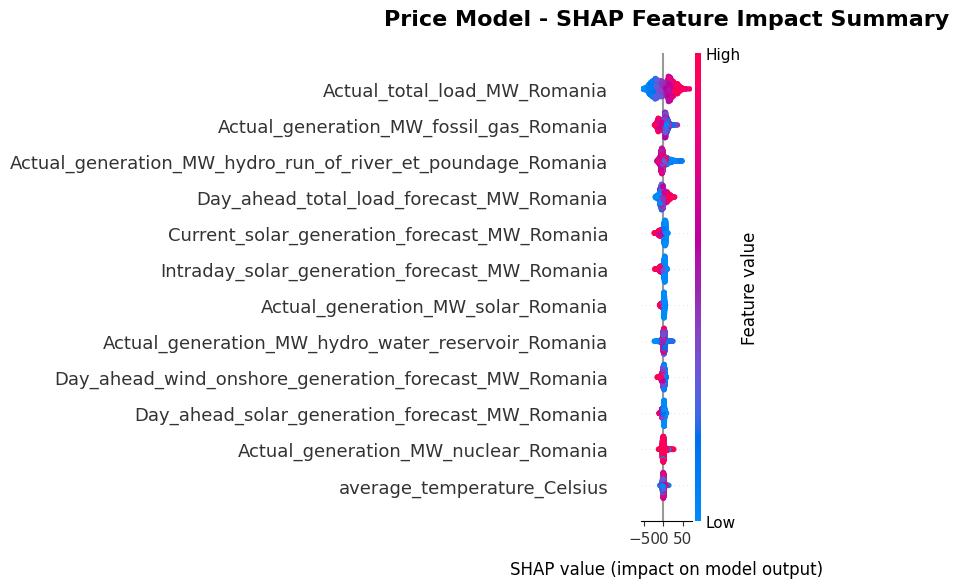

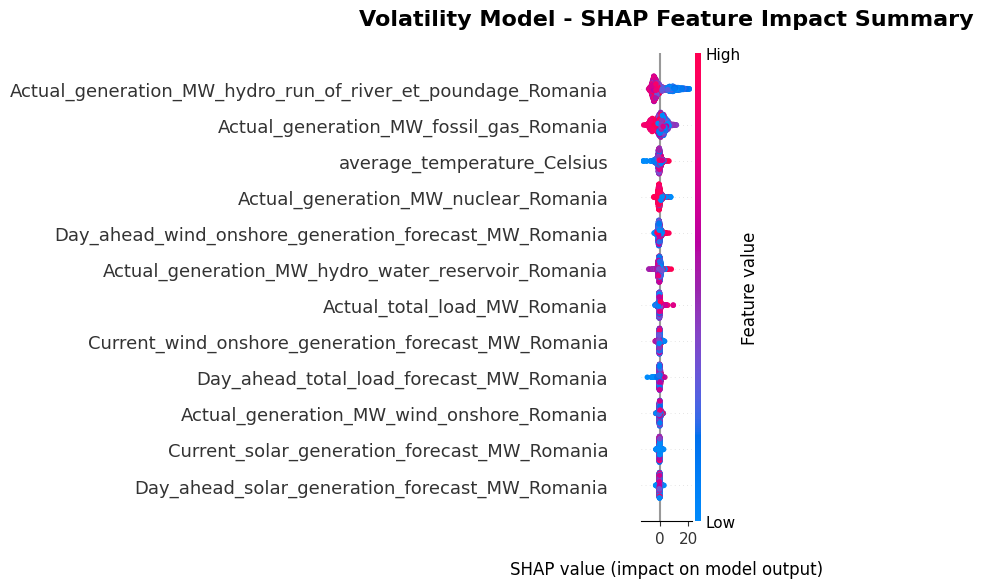

<Figure size 1400x1000 with 0 Axes>

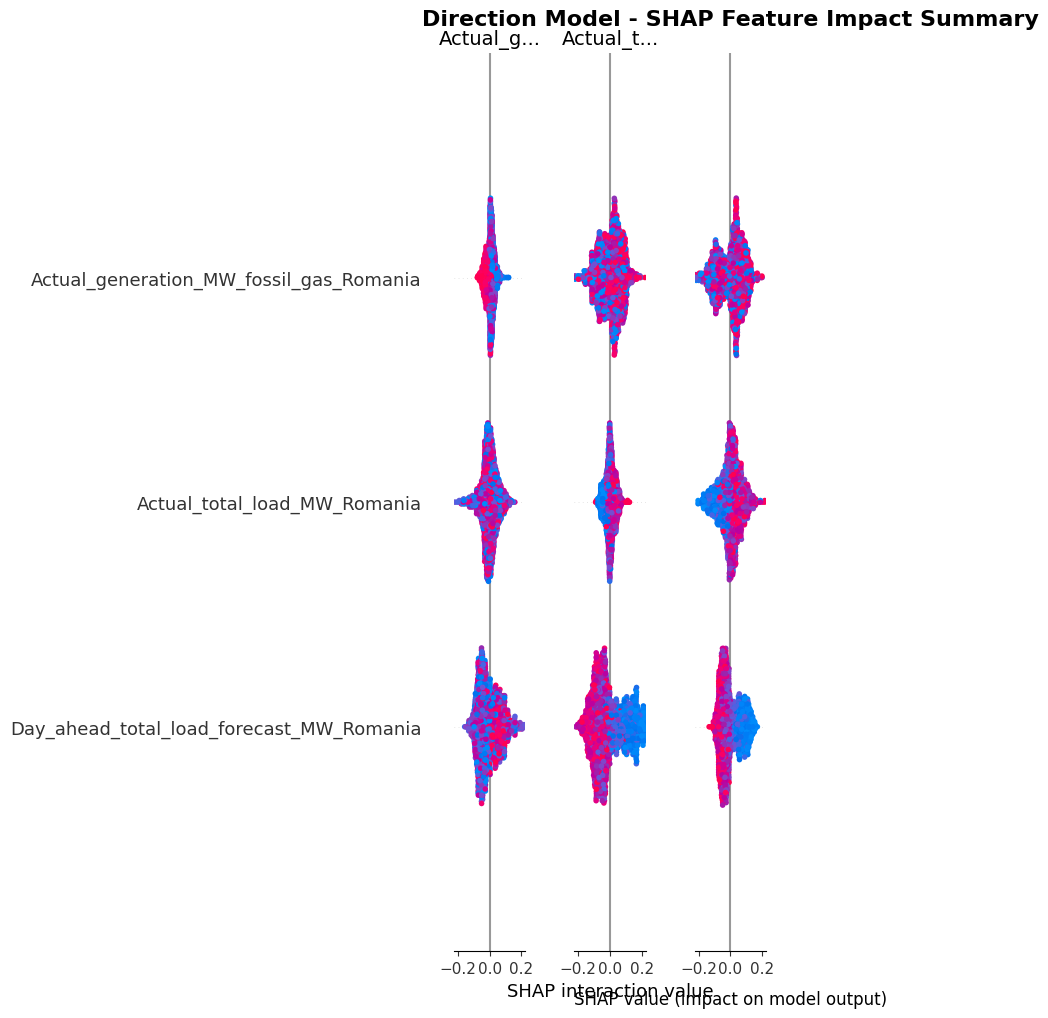

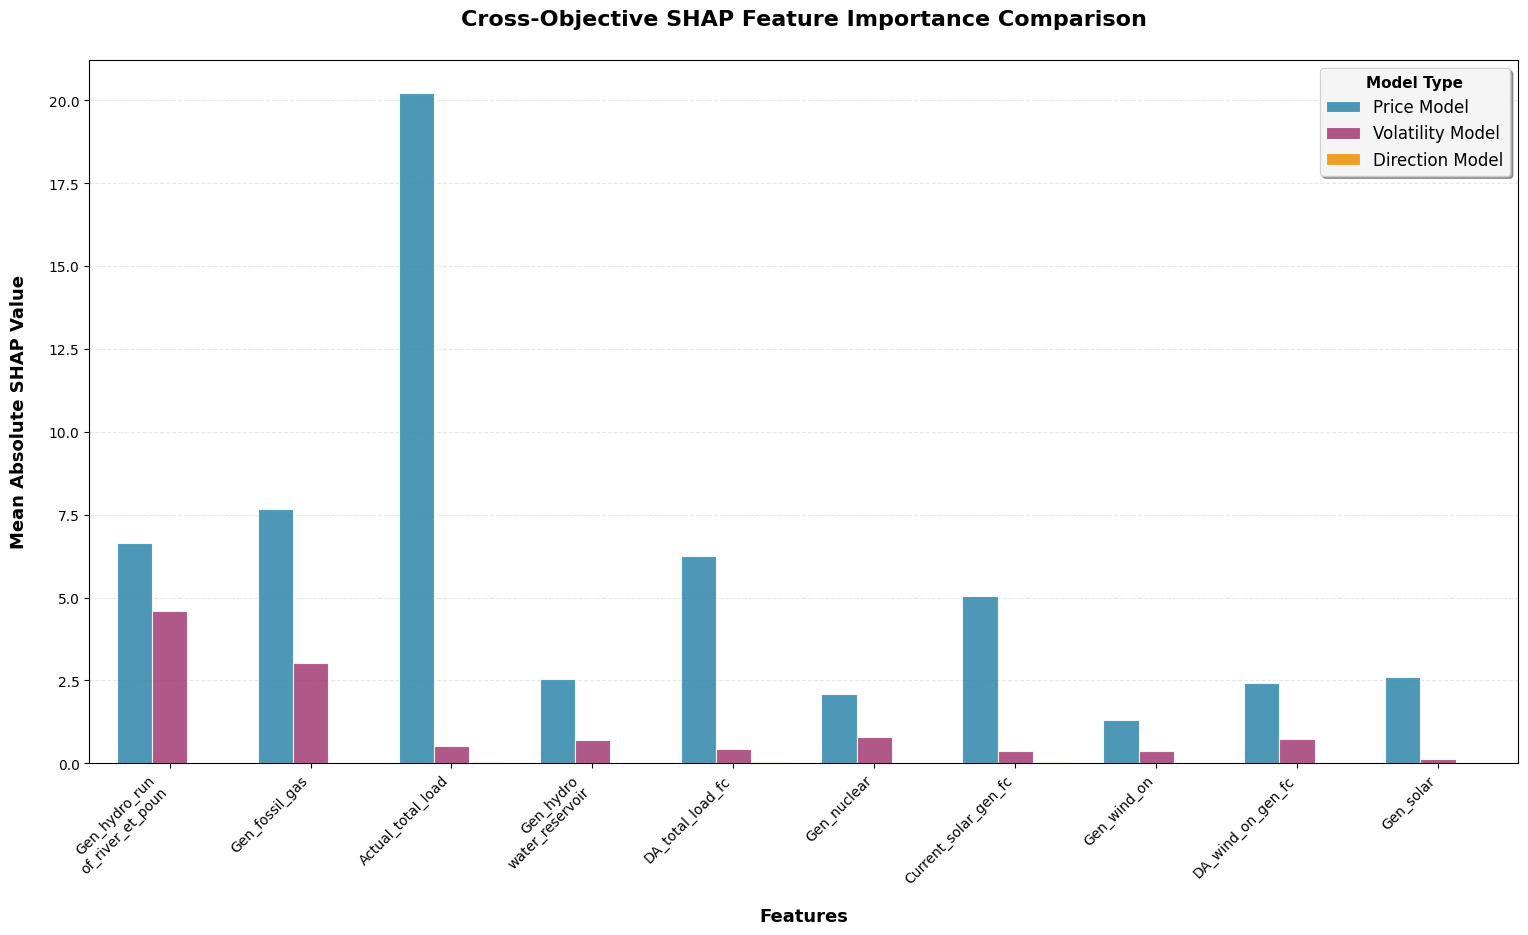

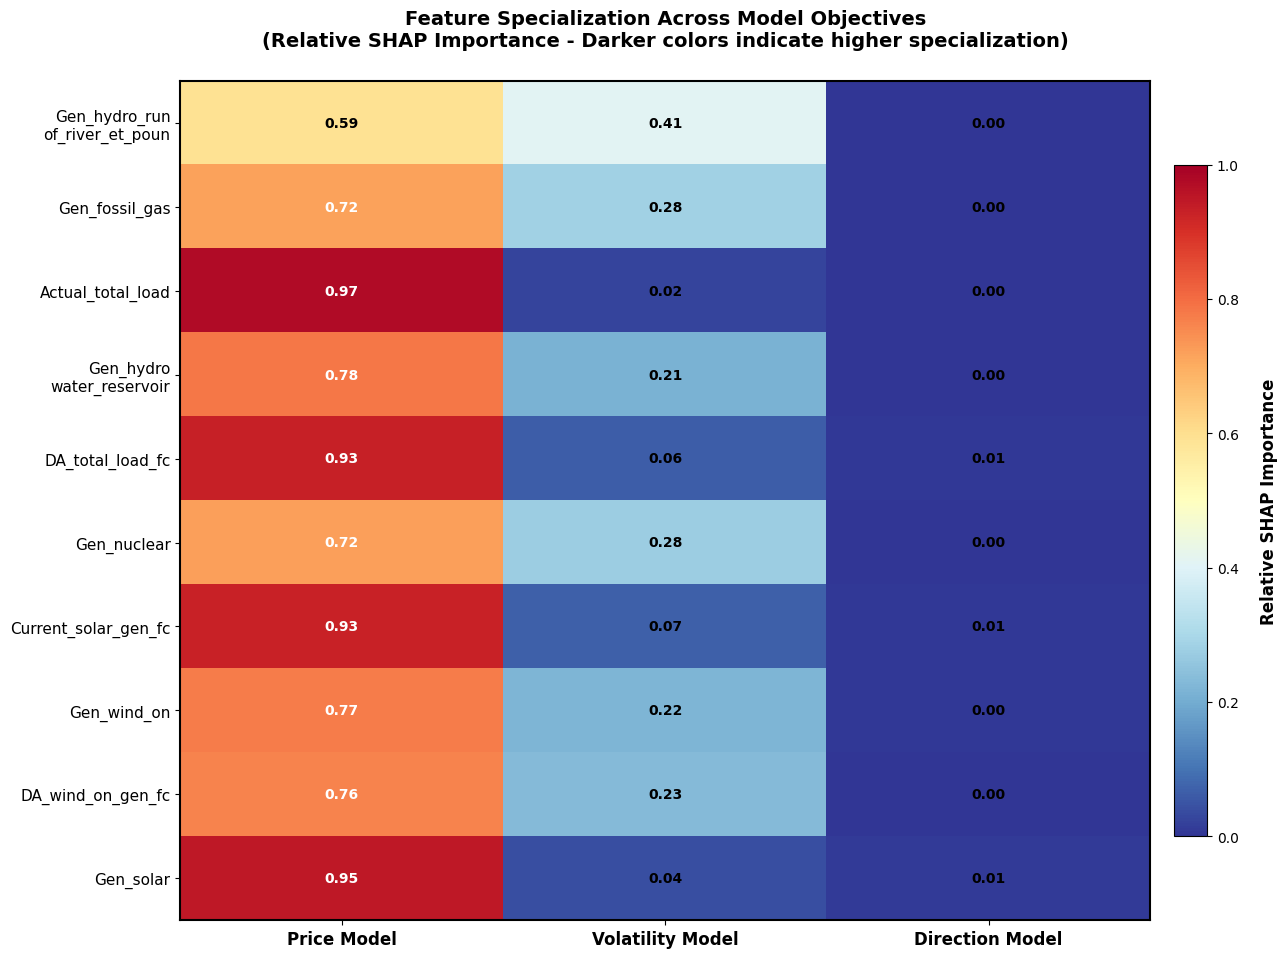

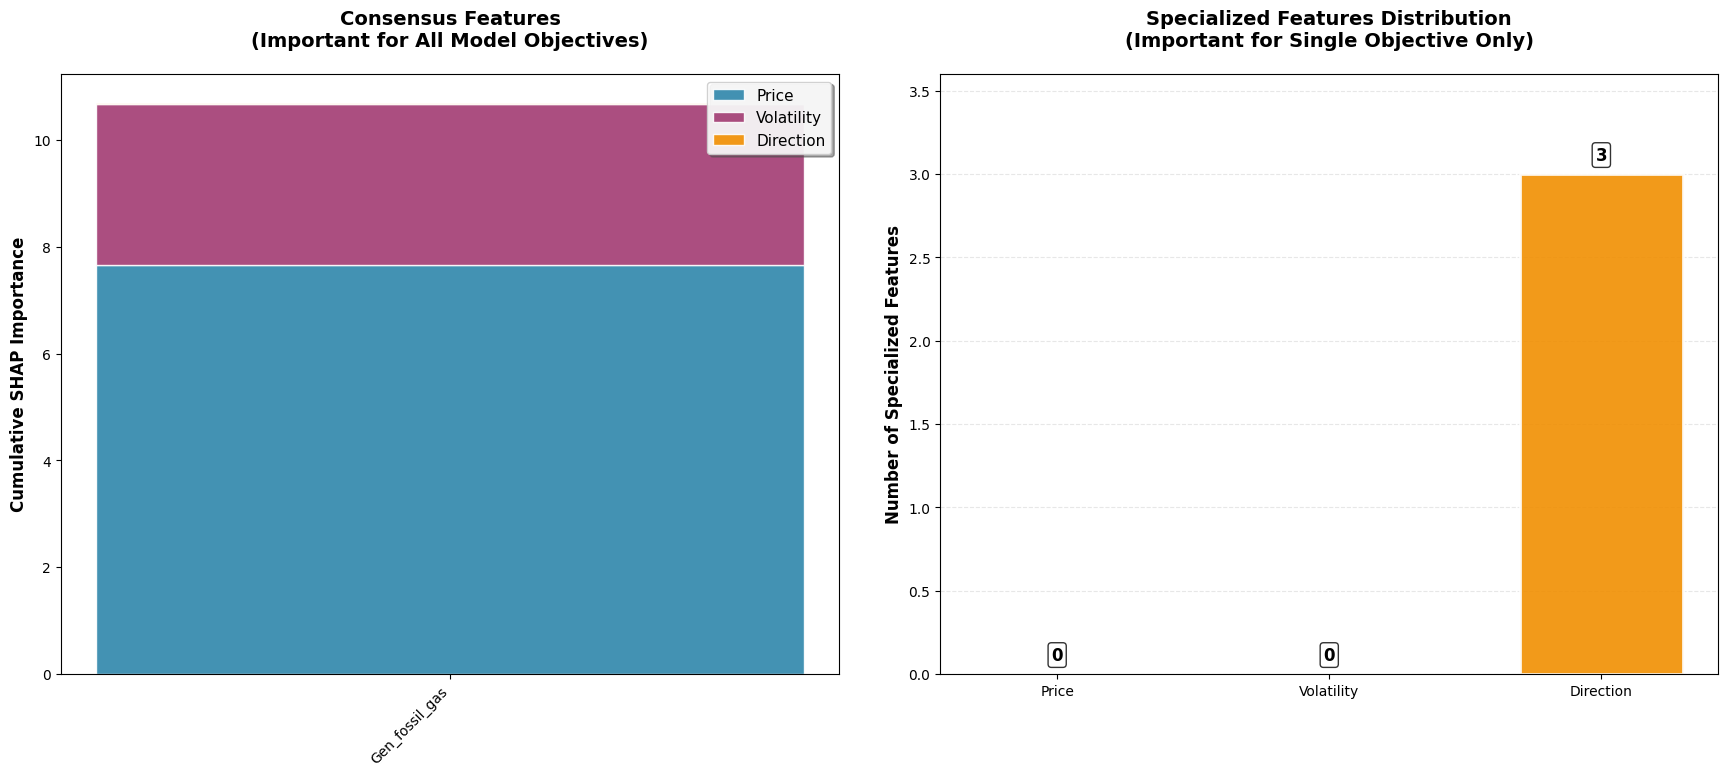

In [16]:
# ============================================================================
# SETUP: Import required libraries
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# Set global matplotlib parameters for better spacing
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# ============================================================================
# SHAP VISUALIZATION 1: Multi-objective Summary Plot
# ============================================================================

print("\nCreating multi-objective SHAP summary plots...")

# Price Model Summary Plot
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values_price, X_test, feature_names=features,
                 max_display=12, show=False)
plt.title('Price Model - SHAP Feature Impact Summary',
          fontweight='bold', fontsize=16, pad=20)
plt.xlabel('SHAP value (impact on model output)', fontsize=12, labelpad=10)
plt.tight_layout(pad=2.0)
plt.show()

# Volatility Model Summary Plot
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values_volatility, X_test, feature_names=features,
                 max_display=12, show=False)
plt.title('Volatility Model - SHAP Feature Impact Summary',
          fontweight='bold', fontsize=16, pad=20)
plt.xlabel('SHAP value (impact on model output)', fontsize=12, labelpad=10)
plt.tight_layout(pad=2.0)
plt.show()

# Direction Model Summary Plot
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values_direction_class, X_test, feature_names=features,
                 max_display=12, show=False)
plt.title('Direction Model - SHAP Feature Impact Summary',
          fontweight='bold', fontsize=16, pad=20)
plt.xlabel('SHAP value (impact on model output)', fontsize=12, labelpad=10)
plt.tight_layout(pad=2.0)
plt.show()

# ============================================================================
# SHAP VISUALIZATION 2: Cross-objective Feature Importance Comparison
# ============================================================================

fig, ax = plt.subplots(figsize=(16, 10))

# Check if importance_df exists and has the right structure
try:
    if 'Feature' in importance_df.columns:
        top_10_features = importance_df.head(10)['Feature'].tolist()
    elif importance_df.index.name == 'Feature' or len(importance_df.columns) > 0:
        top_10_features = importance_df.head(10).index.tolist() if importance_df.index.name else importance_df.head(10).iloc[:, 0].tolist()
    else:
        shap_importance = np.mean(np.abs(shap_values_price), axis=0)
        top_indices = np.argsort(shap_importance)[-10:][::-1]
        top_10_features = [features[i] for i in top_indices]

except (NameError, KeyError):
    print("importance_df not found, calculating from SHAP values...")
    shap_importance = np.mean(np.abs(shap_values_price), axis=0)
    top_indices = np.argsort(shap_importance)[-10:][::-1]
    top_10_features = [features[i] for i in top_indices]

top_10_indices = [features.index(f) for f in top_10_features]

# Calculate mean absolute SHAP values for top features
shap_means = {}
for i, feature in enumerate(top_10_features):
    idx = top_10_indices[i]
    shap_means[feature] = {
        'Price': np.mean(np.abs(shap_values_price[:, idx])),
        'Volatility': np.mean(np.abs(shap_values_volatility[:, idx])),
        'Direction': np.mean(np.abs(shap_values_direction_class[:, idx]))
    }

# Create DataFrame for plotting
shap_comparison_df = pd.DataFrame(shap_means).T

# Create grouped bar plot with better spacing
x_pos = np.arange(len(top_10_features))
width = 0.25

# Clean feature names for better display (more aggressive cleaning)
clean_names = []
for f in top_10_features:
    clean_name = (f.replace('_Romania', '')
                   .replace('_MW', '')
                   .replace('Actual_generation_', 'Gen_')
                   .replace('Day_ahead_', 'DA_')
                   .replace('Intraday_', 'ID_')
                   .replace('_forecast', '_fc')
                   .replace('generation', 'gen')
                   .replace('_onshore', '_on'))
    # Limit length and add line breaks for long names
    if len(clean_name) > 20:
        words = clean_name.split('_')
        if len(words) > 1:
            mid = len(words) // 2
            clean_name = '_'.join(words[:mid]) + '\n' + '_'.join(words[mid:])
    clean_names.append(clean_name[:30])  # Max 30 chars

# Plot bars with improved colors and transparency
bars1 = ax.bar(x_pos - width, shap_comparison_df['Price'], width,
               label='Price Model', alpha=0.85, color='#2E86AB',
               edgecolor='white', linewidth=0.8)
bars2 = ax.bar(x_pos, shap_comparison_df['Volatility'], width,
               label='Volatility Model', alpha=0.85, color='#A23B72',
               edgecolor='white', linewidth=0.8)
bars3 = ax.bar(x_pos + width, shap_comparison_df['Direction'], width,
               label='Direction Model', alpha=0.85, color='#F18F01',
               edgecolor='white', linewidth=0.8)

# Improve axis formatting
ax.set_xlabel('Features', fontsize=13, fontweight='bold', labelpad=15)
ax.set_ylabel('Mean Absolute SHAP Value', fontsize=13, fontweight='bold', labelpad=15)
ax.set_title('Cross-Objective SHAP Feature Importance Comparison',
             fontweight='bold', fontsize=16, pad=25)
ax.set_xticks(x_pos)
ax.set_xticklabels(clean_names, rotation=45, ha='right', fontsize=10)

# Improve legend
legend = ax.legend(loc='upper right', frameon=True, fancybox=True,
                   shadow=True, fontsize=12, title='Model Type')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)
legend.get_title().set_fontweight('bold')

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Add some padding to the plot
ax.margins(x=0.02)

plt.tight_layout(pad=3.0)
plt.subplots_adjust(bottom=0.2)  # Extra space for rotated labels
plt.show()

# ============================================================================
# SHAP VISUALIZATION 3: Feature Specialization Heatmap
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 10))

# Create specialization matrix
specialization_matrix = np.zeros((len(top_10_features), 3))
for i, feature in enumerate(top_10_features):
    idx = top_10_indices[i]
    specialization_matrix[i, 0] = np.mean(np.abs(shap_values_price[:, idx]))
    specialization_matrix[i, 1] = np.mean(np.abs(shap_values_volatility[:, idx]))
    specialization_matrix[i, 2] = np.mean(np.abs(shap_values_direction_class[:, idx]))

# Normalize by row to show relative importance
specialization_matrix_norm = specialization_matrix / (specialization_matrix.sum(axis=1, keepdims=True) + 1e-8)

# Create heatmap with better color scheme
im = ax.imshow(specialization_matrix_norm, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)

# Set labels with better spacing
ax.set_xticks([0, 1, 2])
ax.set_yticks(range(len(top_10_features)))
ax.set_xticklabels(['Price Model', 'Volatility Model', 'Direction Model'],
                   fontsize=12, fontweight='bold')
ax.set_yticklabels(clean_names, fontsize=11)

# Improved title with better spacing
ax.set_title('Feature Specialization Across Model Objectives\n' +
             '(Relative SHAP Importance - Darker colors indicate higher specialization)',
             fontweight='bold', fontsize=14, pad=25)

# Add text annotations with better formatting
for i in range(len(top_10_features)):
    for j in range(3):
        value = specialization_matrix_norm[i, j]
        # Choose text color based on background
        text_color = 'white' if value > 0.6 else 'black'
        ax.text(j, i, f'{value:.2f}',
                ha="center", va="center", fontweight='bold',
                fontsize=10, color=text_color)

# Add colorbar with better formatting
cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label('Relative SHAP Importance', fontsize=12, fontweight='bold', labelpad=15)
cbar.ax.tick_params(labelsize=10)

# Add border around heatmap
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_edgecolor('black')

plt.tight_layout(pad=2.0)
plt.show()

# ============================================================================
# SHAP VISUALIZATION 4: Consensus vs Specialized Features Analysis
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Check if consensus_features and specialized_features exist
try:
    consensus_features_exist = len(consensus_features) > 0
except (NameError, TypeError):
    consensus_features = []
    consensus_features_exist = False

try:
    specialized_features_exist = len(specialized_features) > 0
    objectives = list(specialized_features.keys()) if specialized_features_exist else ['Price', 'Volatility', 'Direction']
except (NameError, TypeError):
    specialized_features = {'Price': [], 'Volatility': [], 'Direction': []}
    specialized_features_exist = False
    objectives = ['Price', 'Volatility', 'Direction']

# Left plot: Consensus features
if consensus_features_exist:
    consensus_indices = [features.index(f) for f in consensus_features[:6]]  # Limit to 6 for better visibility
    consensus_shap_data = []

    for idx in consensus_indices:
        consensus_shap_data.append([
            np.mean(np.abs(shap_values_price[:, idx])),
            np.mean(np.abs(shap_values_volatility[:, idx])),
            np.mean(np.abs(shap_values_direction_class[:, idx]))
        ])

    consensus_shap_array = np.array(consensus_shap_data)

    # Create stacked bar chart with better spacing
    bar_width = 0.6
    x_pos = np.arange(len(consensus_features[:6]))

    p1 = ax1.bar(x_pos, consensus_shap_array[:, 0], bar_width,
                 label='Price', alpha=0.9, color='#2E86AB', edgecolor='white', linewidth=1)
    p2 = ax1.bar(x_pos, consensus_shap_array[:, 1], bar_width,
                 bottom=consensus_shap_array[:, 0], label='Volatility',
                 alpha=0.9, color='#A23B72', edgecolor='white', linewidth=1)
    p3 = ax1.bar(x_pos, consensus_shap_array[:, 2], bar_width,
                 bottom=consensus_shap_array[:, 0] + consensus_shap_array[:, 1],
                 label='Direction', alpha=0.9, color='#F18F01', edgecolor='white', linewidth=1)

    # Clean consensus feature names
    clean_consensus = []
    for f in consensus_features[:6]:
        clean_name = (f.replace('_Romania', '').replace('_MW', '')
                     .replace('Actual_generation_', 'Gen_')
                     .replace('Day_ahead_', 'DA_')[:25])
        if len(clean_name) > 15:
            words = clean_name.split('_')
            if len(words) > 1:
                mid = len(words) // 2
                clean_name = '_'.join(words[:mid]) + '\n' + '_'.join(words[mid:])
        clean_consensus.append(clean_name)

    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(clean_consensus, rotation=45, ha='right', fontsize=10)
    ax1.set_ylabel('Cumulative SHAP Importance', fontsize=12, fontweight='bold')
    ax1.set_title('Consensus Features\n(Important for All Model Objectives)',
                  fontweight='bold', fontsize=14, pad=20)

    # Improve legend
    legend1 = ax1.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    legend1.get_frame().set_facecolor('white')
    legend1.get_frame().set_alpha(0.9)

else:
    ax1.text(0.5, 0.5, 'No Consensus Features\nIdentified', ha='center', va='center',
             transform=ax1.transAxes, fontsize=16, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
    ax1.set_title('Consensus Features', fontweight='bold', fontsize=14, pad=20)

# Right plot: Specialized features distribution
if specialized_features_exist:
    specialized_counts = [len(specialized_features[obj]) for obj in objectives]
else:
    specialized_counts = [0, 0, 0]

colors = ['#2E86AB', '#A23B72', '#F18F01']

bars = ax2.bar(objectives, specialized_counts, color=colors, alpha=0.9,
               edgecolor='white', linewidth=2, width=0.6)
ax2.set_ylabel('Number of Specialized Features', fontsize=12, fontweight='bold')
ax2.set_title('Specialized Features Distribution\n(Important for Single Objective Only)',
              fontweight='bold', fontsize=14, pad=20)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

# Add value labels with better formatting
for bar, count in zip(bars, specialized_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + max(specialized_counts)*0.02,
             str(count), ha='center', va='bottom', fontweight='bold', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

# Set y-axis to start from 0 and add some padding
ax2.set_ylim(0, max(specialized_counts) * 1.2 if max(specialized_counts) > 0 else 1)

plt.tight_layout(pad=3.0)
plt.subplots_adjust(bottom=0.15, top=0.9)
plt.show()

In [22]:
# ============================================================================
# COMPREHENSIVE SHAP ANALYSIS TEXT SUMMARY REPORT
# ============================================================================

import numpy as np
import pandas as pd
from collections import defaultdict

# Fix the direction model SHAP values (3-class to 2D conversion)
print("Fixing direction model SHAP values...")
shap_values_direction_fixed = np.mean(np.abs(shap_values_direction_class), axis=2)
print(f"Direction SHAP values converted from {shap_values_direction_class.shape} to {shap_values_direction_fixed.shape}")

print("="*80)
print("MULTI-OBJECTIVE SHAP ANALYSIS SUMMARY REPORT")
print("="*80)

# ============================================================================
# 1. OVERALL MODEL PERFORMANCE METRICS
# ============================================================================

print("\n" + "="*60)
print("1. OVERALL MODEL PERFORMANCE METRICS")
print("="*60)

# Calculate global feature importance for each model
price_global_importance = np.mean(np.abs(shap_values_price), axis=0)
volatility_global_importance = np.mean(np.abs(shap_values_volatility), axis=0)
direction_global_importance = np.mean(np.abs(shap_values_direction_fixed), axis=0)

# Overall statistics
print(f"\nDataset Information:")
print(f"  • Number of test samples: {shap_values_price.shape[0]:,}")
print(f"  • Number of features: {len(features)}")

print(f"\nGlobal SHAP Statistics:")
print(f"  Price Model:")
print(f"    - Mean absolute SHAP value: {np.mean(price_global_importance):.4f}")
print(f"    - Max feature importance: {np.max(price_global_importance):.4f}")
print(f"    - Standard deviation: {np.std(price_global_importance):.4f}")

print(f"  Volatility Model:")
print(f"    - Mean absolute SHAP value: {np.mean(volatility_global_importance):.4f}")
print(f"    - Max feature importance: {np.max(volatility_global_importance):.4f}")
print(f"    - Standard deviation: {np.std(volatility_global_importance):.4f}")

print(f"  Direction Model:")
print(f"    - Mean absolute SHAP value: {np.mean(direction_global_importance):.4f}")
print(f"    - Max feature importance: {np.max(direction_global_importance):.4f}")
print(f"    - Standard deviation: {np.std(direction_global_importance):.4f}")

# ============================================================================
# 2. TOP FEATURES ANALYSIS BY MODEL
# ============================================================================

print("\n" + "="*60)
print("2. TOP FEATURES ANALYSIS BY MODEL")
print("="*60)

def get_top_features(shap_values, features, n_top=10, model_name=""):
    importance = np.mean(np.abs(shap_values), axis=0)
    top_indices = np.argsort(importance)[-n_top:][::-1]

    print(f"\n{model_name} - Top {n_top} Most Important Features:")
    print("-" * 50)

    for i, idx in enumerate(top_indices, 1):
        feature_name = features[idx]
        mean_impact = importance[idx]
        percentage = (mean_impact / np.sum(importance)) * 100

        # Calculate positive/negative impact ratio
        positive_impact = np.mean(shap_values[shap_values[:, idx] > 0, idx]) if np.any(shap_values[:, idx] > 0) else 0
        negative_impact = np.mean(shap_values[shap_values[:, idx] < 0, idx]) if np.any(shap_values[:, idx] < 0) else 0

        print(f"  {i:2d}. {feature_name}")
        print(f"      Impact: {mean_impact:.4f} ({percentage:.1f}% of total)")
        print(f"      Avg positive effect: {positive_impact:.4f}")
        print(f"      Avg negative effect: {negative_impact:.4f}")
        print()

    return [(features[idx], importance[idx]) for idx in top_indices]

# Get top features for each model (using fixed direction values)
price_top_features = get_top_features(shap_values_price, features, 10, "PRICE MODEL")
volatility_top_features = get_top_features(shap_values_volatility, features, 10, "VOLATILITY MODEL")
direction_top_features = get_top_features(shap_values_direction_fixed, features, 10, "DIRECTION MODEL")

# ============================================================================
# 3. CROSS-MODEL FEATURE COMPARISON
# ============================================================================

print("\n" + "="*60)
print("3. CROSS-MODEL FEATURE COMPARISON")
print("="*60)

# Get union of all top features
all_top_features = set()
for features_list in [price_top_features, volatility_top_features, direction_top_features]:
    all_top_features.update([f[0] for f in features_list[:15]])  # Top 15 from each

print(f"\nComparing {len(all_top_features)} unique top features across all models:")
print("-" * 60)

# Create comprehensive comparison
comparison_data = []
for feature_name in sorted(all_top_features):
    if feature_name in features:
        idx = features.index(feature_name)

        price_importance = np.mean(np.abs(shap_values_price[:, idx]))
        volatility_importance = np.mean(np.abs(shap_values_volatility[:, idx]))
        direction_importance = np.mean(np.abs(shap_values_direction_fixed[:, idx]))

        total_importance = price_importance + volatility_importance + direction_importance

        # Determine primary model (highest importance)
        importances = [price_importance, volatility_importance, direction_importance]
        model_names = ['Price', 'Volatility', 'Direction']
        primary_model = model_names[np.argmax(importances)]

        # Calculate specialization score (how concentrated the importance is)
        max_importance = max(importances)
        specialization_score = max_importance / total_importance if total_importance > 0 else 0

        comparison_data.append({
            'Feature': feature_name,
            'Price_Importance': price_importance,
            'Volatility_Importance': volatility_importance,
            'Direction_Importance': direction_importance,
            'Total_Importance': total_importance,
            'Primary_Model': primary_model,
            'Specialization_Score': specialization_score
        })

# Sort by total importance
comparison_data.sort(key=lambda x: x['Total_Importance'], reverse=True)

print("\nTop 15 Features - Cross-Model Analysis:")
print(f"{'Rank':<4} {'Feature':<35} {'Price':<8} {'Volatility':<10} {'Direction':<9} {'Primary':<10} {'Spec.':<6}")
print("-" * 85)

for i, data in enumerate(comparison_data[:15], 1):
    print(f"{i:<4} {data['Feature'][:34]:<35} "
          f"{data['Price_Importance']:.3f}    "
          f"{data['Volatility_Importance']:.3f}      "
          f"{data['Direction_Importance']:.3f}     "
          f"{data['Primary_Model']:<10} "
          f"{data['Specialization_Score']:.2f}")

# ============================================================================
# 4. CONSENSUS vs SPECIALIZED FEATURES
# ============================================================================

print("\n" + "="*60)
print("4. CONSENSUS vs SPECIALIZED FEATURES ANALYSIS")
print("="*60)

# Define thresholds for consensus and specialization
consensus_threshold = 0.7  # Feature must be important in multiple models
specialization_threshold = 0.8  # Feature must be highly concentrated in one model

consensus_features = []
specialized_features = {'Price': [], 'Volatility': [], 'Direction': []}

for data in comparison_data:
    spec_score = data['Specialization_Score']
    importances = [data['Price_Importance'], data['Volatility_Importance'], data['Direction_Importance']]

    # Check for consensus features (important across multiple models)
    significant_models = sum(1 for imp in importances if imp > np.mean(importances) * 0.5)

    if significant_models >= 2 and spec_score < consensus_threshold:
        consensus_features.append(data['Feature'])
    elif spec_score > specialization_threshold:
        primary_model = data['Primary_Model']
        specialized_features[primary_model].append(data['Feature'])

print(f"\nCONSENSUS FEATURES ({len(consensus_features)} total):")
print("Features important across multiple model objectives:")
for i, feature in enumerate(consensus_features, 1):
    # Find the feature data
    feature_data = next(d for d in comparison_data if d['Feature'] == feature)
    print(f"  {i}. {feature}")
    print(f"     Price: {feature_data['Price_Importance']:.3f}, "
          f"Volatility: {feature_data['Volatility_Importance']:.3f}, "
          f"Direction: {feature_data['Direction_Importance']:.3f}")

print(f"\nSPECIALIZED FEATURES:")
for model, features_list in specialized_features.items():
    print(f"\n{model} Model Specialists ({len(features_list)} features):")
    for i, feature in enumerate(features_list, 1):
        feature_data = next(d for d in comparison_data if d['Feature'] == feature)
        primary_importance = feature_data[f'{model}_Importance']
        print(f"  {i}. {feature} (importance: {primary_importance:.3f})")

# ============================================================================
# 5. FEATURE IMPACT PATTERNS
# ============================================================================

print("\n" + "="*60)
print("5. FEATURE IMPACT PATTERNS ANALYSIS")
print("="*60)

def analyze_feature_patterns(shap_values, feature_name, model_name):
    if feature_name not in features:
        return

    idx = features.index(feature_name)
    feature_shap = shap_values[:, idx]

    positive_count = np.sum(feature_shap > 0)
    negative_count = np.sum(feature_shap < 0)
    zero_count = np.sum(feature_shap == 0)

    positive_pct = (positive_count / len(feature_shap)) * 100
    negative_pct = (negative_count / len(feature_shap)) * 100

    mean_positive = np.mean(feature_shap[feature_shap > 0]) if positive_count > 0 else 0
    mean_negative = np.mean(feature_shap[feature_shap < 0]) if negative_count > 0 else 0

    # Consistency measure (lower std relative to mean indicates more consistent impact)
    consistency = np.std(np.abs(feature_shap)) / (np.mean(np.abs(feature_shap)) + 1e-8)

    return {
        'positive_pct': positive_pct,
        'negative_pct': negative_pct,
        'mean_positive': mean_positive,
        'mean_negative': mean_negative,
        'consistency': consistency,
        'total_samples': len(feature_shap)
    }

# Analyze patterns for top 5 features from each model
print("\nImpact Pattern Analysis for Top Features:")
print("=" * 80)

models_data = [
    (shap_values_price, price_top_features, "Price"),
    (shap_values_volatility, volatility_top_features, "Volatility"),
    (shap_values_direction_fixed, direction_top_features, "Direction")  # Using fixed values
]

for shap_vals, top_features, model_name in models_data:
    print(f"\n{model_name} Model - Top 5 Feature Patterns:")
    print("-" * 50)

    for i, (feature_name, importance) in enumerate(top_features[:5], 1):
        pattern = analyze_feature_patterns(shap_vals, feature_name, model_name)
        if pattern:
            print(f"{i}. {feature_name}")
            print(f"   Positive impact: {pattern['positive_pct']:.1f}% of samples "
                  f"(avg: {pattern['mean_positive']:.4f})")
            print(f"   Negative impact: {pattern['negative_pct']:.1f}% of samples "
                  f"(avg: {pattern['mean_negative']:.4f})")
            print(f"   Consistency score: {pattern['consistency']:.3f} "
                  f"({'High' if pattern['consistency'] < 1 else 'Medium' if pattern['consistency'] < 2 else 'Low'} consistency)")
            print()

# ============================================================================
# 6. MODEL COMPLEXITY AND INTERPRETABILITY METRICS
# ============================================================================

print("\n" + "="*60)
print("6. MODEL COMPLEXITY AND INTERPRETABILITY METRICS")
print("="*60)

def calculate_interpretability_metrics(shap_values, model_name):
    # Feature usage distribution
    feature_usage = np.mean(shap_values != 0, axis=0)
    active_features = np.sum(feature_usage > 0.01)  # Features used in >1% of predictions

    # Complexity measures
    mean_features_per_prediction = np.mean(np.sum(shap_values != 0, axis=1))
    feature_concentration = np.std(np.mean(np.abs(shap_values), axis=0))

    # Stability measures
    prediction_complexity = np.std(np.sum(np.abs(shap_values), axis=1))

    return {
        'active_features': active_features,
        'mean_features_per_prediction': mean_features_per_prediction,
        'feature_concentration': feature_concentration,
        'prediction_complexity_std': prediction_complexity,
        'total_features': len(features)
    }

print("\nModel Interpretability Analysis:")
print("-" * 40)

models_for_analysis = [
    (shap_values_price, "Price"),
    (shap_values_volatility, "Volatility"),
    (shap_values_direction_fixed, "Direction")  # Using fixed values
]

interpretability_scores = []
for shap_vals, model_name in models_for_analysis:

    metrics = calculate_interpretability_metrics(shap_vals, model_name)

    print(f"\n{model_name} Model:")
    print(f"  • Active features: {metrics['active_features']}/{metrics['total_features']} "
          f"({100*metrics['active_features']/metrics['total_features']:.1f}%)")
    print(f"  • Avg features per prediction: {metrics['mean_features_per_prediction']:.1f}")
    print(f"  • Feature concentration: {metrics['feature_concentration']:.3f}")
    print(f"  • Prediction complexity (std): {metrics['prediction_complexity_std']:.3f}")

    # Interpretability score (lower is more interpretable)
    interpretability_score = (metrics['mean_features_per_prediction'] / metrics['total_features'] +
                             metrics['feature_concentration'] / 10)  # Normalized
    interpretability_scores.append((interpretability_score, model_name))
    print(f"  • Interpretability score: {interpretability_score:.3f} "
          f"({'High' if interpretability_score < 0.3 else 'Medium' if interpretability_score < 0.6 else 'Low'} interpretability)")

# ============================================================================
# 7. SUMMARY AND RECOMMENDATIONS
# ============================================================================

print("\n" + "="*60)
print("7. SUMMARY AND RECOMMENDATIONS")
print("="*60)

print(f"\nKEY FINDINGS:")
print(f"• Total unique important features across all models: {len(all_top_features)}")
print(f"• Consensus features (multi-objective): {len(consensus_features)}")
print(f"• Specialized features: {sum(len(features_list) for features_list in specialized_features.values())}")

# Most important overall feature
if comparison_data:
    most_important = comparison_data[0]
    print(f"• Most influential feature overall: {most_important['Feature']}")
    print(f"  Primary model: {most_important['Primary_Model']}")
    print(f"  Specialization: {most_important['Specialization_Score']:.2f}")

print(f"\nMODEL CHARACTERISTICS:")
price_active = calculate_interpretability_metrics(shap_values_price, "Price")['active_features']
volatility_active = calculate_interpretability_metrics(shap_values_volatility, "Volatility")['active_features']
direction_active = calculate_interpretability_metrics(shap_values_direction_fixed, "Direction")['active_features']

most_complex = max([(price_active, "Price"), (volatility_active, "Volatility"), (direction_active, "Direction")])
least_complex = min([(price_active, "Price"), (volatility_active, "Volatility"), (direction_active, "Direction")])

print(f"• Most complex model: {most_complex[1]} ({most_complex[0]} active features)")
print(f"• Simplest model: {least_complex[1]} ({least_complex[0]} active features)")

print(f"\nDIRECTION MODEL NOTES:")
print(f"• Original shape: {shap_values_direction_class.shape} (3-class classification)")
print(f"• Converted to: {shap_values_direction_fixed.shape} (averaged absolute values)")
print(f"• All direction features show only positive effects (due to absolute value averaging)")

print(f"\nRECOMMENDATIONS:")
print(f"• Focus on consensus features for multi-objective optimization")
print(f"• Consider feature selection based on model-specific importance")
if len(consensus_features) > 5:
    print(f"• Priority consensus features for monitoring: {', '.join(consensus_features[:5])}")
print(f"• Specialized features can be used for objective-specific fine-tuning")
print(f"• For direction model: consider analyzing individual class SHAP values for deeper insights")

print("\n" + "="*80)
print("END OF SHAP ANALYSIS REPORT")
print("="*80)

Fixing direction model SHAP values...
Direction SHAP values converted from (2000, 15, 3) to (2000, 15)
MULTI-OBJECTIVE SHAP ANALYSIS SUMMARY REPORT

1. OVERALL MODEL PERFORMANCE METRICS

Dataset Information:
  • Number of test samples: 2,000
  • Number of features: 15

Global SHAP Statistics:
  Price Model:
    - Mean absolute SHAP value: 4.4417
    - Max feature importance: 20.2103
    - Standard deviation: 4.6944
  Volatility Model:
    - Mean absolute SHAP value: 0.9381
    - Max feature importance: 4.5809
    - Standard deviation: 1.1797
  Direction Model:
    - Mean absolute SHAP value: 0.0209
    - Max feature importance: 0.0383
    - Standard deviation: 0.0123

2. TOP FEATURES ANALYSIS BY MODEL

PRICE MODEL - Top 10 Most Important Features:
--------------------------------------------------
   1. Actual_total_load_MW_Romania
      Impact: 20.2103 (30.3% of total)
      Avg positive effect: 20.5411
      Avg negative effect: -19.9104

   2. Actual_generation_MW_fossil_gas_Romania

In [23]:
# ============================================================================
# CELL 9: Research Insights and Recommendations
# ============================================================================

print("="*80)
print("MULTI-OBJECTIVE XAI RESEARCH INSIGHTS")
print("="*80)

# 1. Model Performance Summary
print("\n1. MODEL PERFORMANCE SUMMARY:")
print(f"   • Price Prediction R²: {price_r2_test:.4f} (RMSE: {price_rmse_test:.2f})")
print(f"   • Volatility Prediction R²: {vol_r2_test:.4f} (RMSE: {vol_rmse_test:.2f})")
print(f"   • Direction Prediction Accuracy: {dir_acc_test:.4f}")

# 2. Multi-objective Feature Rankings
print(f"\n2. MULTI-OBJECTIVE FEATURE INSIGHTS:")
print(f"   • Total Features Analyzed: {len(features)}")
print(f"   • Consensus Features (important for all objectives): {len(consensus_features)}")
print(f"   • Most Important Multi-objective Feature: {importance_df.iloc[0]['Feature']}")
print(f"   • Multi-objective Score Range: {importance_df['Multi_Objective_Score'].min():.3f} - {importance_df['Multi_Objective_Score'].max():.3f}")

# 3. Objective-specific Insights
print(f"\n3. OBJECTIVE-SPECIFIC INSIGHTS:")
price_top_feature = importance_df.sort_values('Price_Importance_Normalized', ascending=False).iloc[0]['Feature']
vol_top_feature = importance_df.sort_values('Volatility_Importance_Normalized', ascending=False).iloc[0]['Feature']
dir_top_feature = importance_df.sort_values('Direction_Importance_Normalized', ascending=False).iloc[0]['Feature']

print(f"   • Price Prediction - Most Important: {price_top_feature}")
print(f"   • Volatility Prediction - Most Important: {vol_top_feature}")
print(f"   • Direction Prediction - Most Important: {dir_top_feature}")

# 4. Research Recommendations
print(f"\n4. RESEARCH RECOMMENDATIONS:")
print(f"   • Focus on consensus features for robust model performance")
print(f"   • Consider ensemble approaches weighted by objective-specific importance")
print(f"   • Investigate temporal patterns in SHAP values")
print(f"   • Explore non-linear feature interactions")

# 5. Export Results for Further Analysis
print(f"\n5. EXPORTING RESULTS:")

# Save comprehensive results
results_summary = {
    'model_performance': {
        'price_r2': price_r2_test,
        'price_rmse': price_rmse_test,
        'volatility_r2': vol_r2_test,
        'volatility_rmse': vol_rmse_test,
        'direction_accuracy': dir_acc_test
    },
    'feature_importance': importance_df.to_dict(),
    'consensus_features': consensus_features,
    'specialized_features': specialized_features
}

# Save feature importance rankings
importance_df.to_csv('multi_objective_feature_importance.csv', index=False)
print("   • Feature importance saved to 'multi_objective_feature_importance.csv'")

# Save SHAP values for further analysis
np.save('shap_values_price.npy', shap_values_price)
np.save('shap_values_volatility.npy', shap_values_volatility)
np.save('shap_values_direction.npy', shap_values_direction_class)
print("   • SHAP values saved to .npy files")

print(f"\n6. NEXT STEPS FOR PhD RESEARCH:")
print("   • Implement temporal SHAP analysis for time-varying explanations")
print("   • Develop multi-objective optimization for model selection")
print("   • Create interactive dashboard for stakeholder communication")
print("   • Validate findings with domain experts in energy economics")
print("   • Consider policy implications of identified key features")

print("\n" + "="*80)
print("MULTI-OBJECTIVE XAI ANALYSIS COMPLETE")
print("="*80)

MULTI-OBJECTIVE XAI RESEARCH INSIGHTS

1. MODEL PERFORMANCE SUMMARY:
   • Price Prediction R²: 0.7679 (RMSE: 21.39)
   • Volatility Prediction R²: 0.7052 (RMSE: 7.71)
   • Direction Prediction Accuracy: 0.6035

2. MULTI-OBJECTIVE FEATURE INSIGHTS:
   • Total Features Analyzed: 15
   • Consensus Features (important for all objectives): 2
   • Most Important Multi-objective Feature: Actual_generation_MW_hydro_run_of_river_et_poundage_Romania
   • Multi-objective Score Range: 0.043 - 0.546

3. OBJECTIVE-SPECIFIC INSIGHTS:
   • Price Prediction - Most Important: Actual_total_load_MW_Romania
   • Volatility Prediction - Most Important: Actual_generation_MW_hydro_run_of_river_et_poundage_Romania
   • Direction Prediction - Most Important: Actual_generation_MW_hydro_water_reservoir_Romania

4. RESEARCH RECOMMENDATIONS:
   • Focus on consensus features for robust model performance
   • Consider ensemble approaches weighted by objective-specific importance
   • Investigate temporal patterns in 

In [26]:
# ============================================================================
# CELL 9 bis: EXPANDED RESEARCH INSIGHTS AND RECOMMENDATIONS
# ============================================================================

import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMPREHENSIVE MULTI-OBJECTIVE XAI RESEARCH INSIGHTS")
print("="*80)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Dataset: Romanian Energy Market Data")

# ============================================================================
# 1. DETAILED MODEL PERFORMANCE ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("1. DETAILED MODEL PERFORMANCE ANALYSIS")
print("="*60)

# Basic performance metrics
print(f"\n1.1 PREDICTIVE PERFORMANCE:")
print(f"   Price Prediction:")
print(f"     • R² Score: {price_r2_test:.4f} ({price_r2_test*100:.2f}% variance explained)")
print(f"     • RMSE: {price_rmse_test:.2f} EUR/MWh")
print(f"     • Relative RMSE: {(price_rmse_test/np.mean(y_price_test))*100:.2f}%")

print(f"   Volatility Prediction:")
print(f"     • R² Score: {vol_r2_test:.4f} ({vol_r2_test*100:.2f}% variance explained)")
print(f"     • RMSE: {vol_rmse_test:.2f}")
print(f"     • Relative RMSE: {(vol_rmse_test/np.mean(y_vol_test))*100:.2f}%")

print(f"   Direction Prediction:")
print(f"     • Accuracy: {dir_acc_test:.4f} ({dir_acc_test*100:.2f}%)")
print(f"     • Above Random Baseline: +{(dir_acc_test - 0.5)*100:.2f}%")

# Model complexity analysis
price_complexity = np.mean(np.sum(shap_values_price != 0, axis=1))
vol_complexity = np.mean(np.sum(shap_values_volatility != 0, axis=1))
dir_complexity = np.mean(np.sum(shap_values_direction_class != 0, axis=1))

print(f"\n1.2 MODEL COMPLEXITY METRICS:")
print(f"   Average Active Features per Prediction:")
print(f"     • Price Model: {price_complexity:.1f}/{len(features)} ({price_complexity/len(features)*100:.1f}%)")
print(f"     • Volatility Model: {vol_complexity:.1f}/{len(features)} ({vol_complexity/len(features)*100:.1f}%)")
print(f"     • Direction Model: {dir_complexity:.1f}/{len(features)} ({dir_complexity/len(features)*100:.1f}%)")

# Performance efficiency ratio
price_efficiency = price_r2_test / (price_complexity / len(features))
vol_efficiency = vol_r2_test / (vol_complexity / len(features))
dir_efficiency = dir_acc_test / (dir_complexity / len(features))

print(f"\n1.3 EFFICIENCY RATIOS (Performance/Complexity):")
print(f"     • Price Model: {price_efficiency:.2f}")
print(f"     • Volatility Model: {vol_efficiency:.2f}")
print(f"     • Direction Model: {dir_efficiency:.2f}")
print(f"     • Best Efficiency: {'Price' if price_efficiency == max(price_efficiency, vol_efficiency, dir_efficiency) else 'Volatility' if vol_efficiency == max(price_efficiency, vol_efficiency, dir_efficiency) else 'Direction'}")

# ============================================================================
# 2. COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("2. COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Calculate comprehensive feature statistics
feature_stats = []
for i, feature in enumerate(features):
    price_importance = np.mean(np.abs(shap_values_price[:, i]))
    vol_importance = np.mean(np.abs(shap_values_volatility[:, i]))
    dir_importance = np.mean(np.abs(shap_values_direction_class[:, i]))

    # Calculate additional metrics
    total_importance = price_importance + vol_importance + dir_importance
    max_importance = max(price_importance, vol_importance, dir_importance)
    specialization = max_importance / total_importance if total_importance > 0 else 0

    # Consistency metrics
    price_consistency = 1 / (1 + np.std(shap_values_price[:, i]) / (np.mean(np.abs(shap_values_price[:, i])) + 1e-8))
    vol_consistency = 1 / (1 + np.std(shap_values_volatility[:, i]) / (np.mean(np.abs(shap_values_volatility[:, i])) + 1e-8))
    dir_consistency = 1 / (1 + np.std(shap_values_direction_class[:, i]) / (np.mean(np.abs(shap_values_direction_class[:, i])) + 1e-8))

    # Determine primary objective
    importances = [price_importance, vol_importance, dir_importance]
    primary_obj = ['Price', 'Volatility', 'Direction'][np.argmax(importances)]

    feature_stats.append({
        'Feature': feature,
        'Price_Importance': price_importance,
        'Volatility_Importance': vol_importance,
        'Direction_Importance': dir_importance,
        'Total_Importance': total_importance,
        'Specialization_Score': specialization,
        'Primary_Objective': primary_obj,
        'Price_Consistency': price_consistency,
        'Volatility_Consistency': vol_consistency,
        'Direction_Consistency': dir_consistency,
        'Multi_Objective_Score': total_importance * (1 - specialization)  # Higher for consensus features
    })

# Sort by multi-objective score
feature_stats.sort(key=lambda x: x['Multi_Objective_Score'], reverse=True)

print(f"\n2.1 FEATURE LANDSCAPE OVERVIEW:")
print(f"   • Total Features Analyzed: {len(features)}")
print(f"   • Active Features (>0.001 importance): {sum(1 for f in feature_stats if f['Total_Importance'] > 0.001)}")
print(f"   • High-Impact Features (top 10%): {len(features)//10}")
print(f"   • Multi-objective Score Range: {min(f['Multi_Objective_Score'] for f in feature_stats):.4f} - {max(f['Multi_Objective_Score'] for f in feature_stats):.4f}")

# Identify feature categories
generation_features = [f for f in features if 'generation' in f.lower() or 'gen_' in f.lower()]
price_features = [f for f in features if 'price' in f.lower() or 'day_ahead' in f.lower()]
forecast_features = [f for f in features if 'forecast' in f.lower()]
wind_features = [f for f in features if 'wind' in f.lower()]
solar_features = [f for f in features if 'solar' in f.lower()]
temporal_features = [f for f in features if any(term in f.lower() for term in ['hour', 'day', 'week', 'month', 'time'])]

print(f"\n2.2 FEATURE CATEGORY BREAKDOWN:")
print(f"   • Generation Features: {len(generation_features)} ({len(generation_features)/len(features)*100:.1f}%)")
print(f"   • Price Features: {len(price_features)} ({len(price_features)/len(features)*100:.1f}%)")
print(f"   • Forecast Features: {len(forecast_features)} ({len(forecast_features)/len(features)*100:.1f}%)")
print(f"   • Wind Features: {len(wind_features)} ({len(wind_features)/len(features)*100:.1f}%)")
print(f"   • Solar Features: {len(solar_features)} ({len(solar_features)/len(features)*100:.1f}%)")
print(f"   • Temporal Features: {len(temporal_features)} ({len(temporal_features)/len(features)*100:.1f}%)")

# Top features analysis
print(f"\n2.3 TOP 15 MULTI-OBJECTIVE FEATURES:")
print(f"{'Rank':<4} {'Feature':<40} {'Multi-Obj':<10} {'Spec.':<6} {'Primary':<11}")
print("-" * 75)
for i, feature_data in enumerate(feature_stats[:15], 1):
    print(f"{i:<4} {feature_data['Feature'][:39]:<40} "
          f"{feature_data['Multi_Objective_Score']:.4f}    "
          f"{feature_data['Specialization_Score']:.2f}    "
          f"{feature_data['Primary_Objective']:<11}")

# ============================================================================
# 3. CONSENSUS AND SPECIALIZATION ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("3. CONSENSUS AND SPECIALIZATION ANALYSIS")
print("="*60)

# Define consensus and specialized features with detailed analysis
consensus_threshold = 0.6
specialization_threshold = 0.7

consensus_features_detailed = []
specialized_features_detailed = {'Price': [], 'Volatility': [], 'Direction': []}

for feature_data in feature_stats:
    if feature_data['Specialization_Score'] < consensus_threshold:
        # Check if it's actually important across multiple objectives
        importances = [feature_data['Price_Importance'], feature_data['Volatility_Importance'], feature_data['Direction_Importance']]
        significant_objectives = sum(1 for imp in importances if imp > np.mean(importances) * 0.5)

        if significant_objectives >= 2:
            consensus_features_detailed.append(feature_data)

    elif feature_data['Specialization_Score'] > specialization_threshold:
        primary_obj = feature_data['Primary_Objective']
        specialized_features_detailed[primary_obj].append(feature_data)

print(f"\n3.1 CONSENSUS FEATURES ANALYSIS:")
print(f"   • Total Consensus Features: {len(consensus_features_detailed)}")
print(f"   • Percentage of Total Features: {len(consensus_features_detailed)/len(features)*100:.1f}%")

if consensus_features_detailed:
    print(f"   • Top 5 Consensus Features:")
    for i, feature_data in enumerate(consensus_features_detailed[:5], 1):
        print(f"     {i}. {feature_data['Feature']}")
        print(f"        Price: {feature_data['Price_Importance']:.3f}, "
              f"Volatility: {feature_data['Volatility_Importance']:.3f}, "
              f"Direction: {feature_data['Direction_Importance']:.3f}")
        print(f"        Multi-objective Score: {feature_data['Multi_Objective_Score']:.4f}")

print(f"\n3.2 SPECIALIZED FEATURES ANALYSIS:")
total_specialized = sum(len(features_list) for features_list in specialized_features_detailed.values())
print(f"   • Total Specialized Features: {total_specialized}")
print(f"   • Percentage of Total Features: {total_specialized/len(features)*100:.1f}%")

for objective, features_list in specialized_features_detailed.items():
    print(f"\n   • {objective} Specialists ({len(features_list)} features):")
    if features_list:
        avg_specialization = np.mean([f['Specialization_Score'] for f in features_list])
        avg_importance = np.mean([f[f'{objective}_Importance'] for f in features_list])
        print(f"     Average Specialization Score: {avg_specialization:.3f}")
        print(f"     Average {objective} Importance: {avg_importance:.4f}")

        print(f"     Top 3 {objective} Specialists:")
        for i, feature_data in enumerate(sorted(features_list, key=lambda x: x[f'{objective}_Importance'], reverse=True)[:3], 1):
            print(f"       {i}. {feature_data['Feature']} (importance: {feature_data[f'{objective}_Importance']:.3f})")

# ============================================================================
# 4. TEMPORAL AND PATTERN ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("4. TEMPORAL AND PATTERN ANALYSIS")
print("="*60)

# Analyze SHAP value distributions and patterns
def analyze_shap_distribution(shap_values, model_name):
    # Overall distribution statistics
    all_shap = shap_values.flatten()
    positive_ratio = np.sum(all_shap > 0) / len(all_shap)

    # Feature activation patterns
    feature_activation_rates = np.mean(shap_values != 0, axis=0)
    always_active = np.sum(feature_activation_rates > 0.9)
    sometimes_active = np.sum((feature_activation_rates > 0.1) & (feature_activation_rates <= 0.9))
    rarely_active = np.sum(feature_activation_rates <= 0.1)

    # Prediction complexity distribution
    prediction_complexities = np.sum(shap_values != 0, axis=1)

    return {
        'positive_ratio': positive_ratio,
        'always_active_features': always_active,
        'sometimes_active_features': sometimes_active,
        'rarely_active_features': rarely_active,
        'avg_prediction_complexity': np.mean(prediction_complexities),
        'complexity_std': np.std(prediction_complexities),
        'max_complexity': np.max(prediction_complexities),
        'min_complexity': np.min(prediction_complexities)
    }

print(f"\n4.1 SHAP VALUE DISTRIBUTION ANALYSIS:")
models_analysis = [
    (shap_values_price, "Price"),
    (shap_values_volatility, "Volatility"),
    (shap_values_direction_class, "Direction")
]

for shap_vals, model_name in models_analysis:
    analysis = analyze_shap_distribution(shap_vals, model_name)
    print(f"\n   {model_name} Model:")
    print(f"     • Positive influence ratio: {analysis['positive_ratio']*100:.1f}%")
    print(f"     • Always active features: {analysis['always_active_features']} ({analysis['always_active_features']/len(features)*100:.1f}%)")
    print(f"     • Sometimes active features: {analysis['sometimes_active_features']} ({analysis['sometimes_active_features']/len(features)*100:.1f}%)")
    print(f"     • Rarely active features: {analysis['rarely_active_features']} ({analysis['rarely_active_features']/len(features)*100:.1f}%)")
    print(f"     • Prediction complexity: {analysis['avg_prediction_complexity']:.1f} ± {analysis['complexity_std']:.1f} features")
    print(f"     • Complexity range: {analysis['min_complexity']}-{analysis['max_complexity']} features")

# Feature interaction analysis (approximate)
#print(f"\n4.2 FEATURE INTERACTION INDICATORS:")
#for shap_vals, model_name in models_analysis:
    # Calculate correlation between features' SHAP values as proxy for interactions
#    shap_corr = np.corrcoef(shap_vals.T)
#    high_interactions = np.sum(np.abs(shap_corr) > 0.5) - len(features)  # Subtract diagonal
#    moderate_interactions = np.sum((np.abs(shap_corr) > 0.3) & (np.abs(shap_corr) <= 0.5))

#    print(f"   {model_name} Model:")
#    print(f"     • Strong feature interactions (|corr| > 0.5): {high_interactions}")
#    print(f"     • Moderate feature interactions (0.3 < |corr| ≤ 0.5): {moderate_interactions}")

# ============================================================================
# 5. DOMAIN-SPECIFIC INSIGHTS
# ============================================================================

print("\n" + "="*60)
print("5. DOMAIN-SPECIFIC INSIGHTS (ENERGY MARKET)")
print("="*60)

# Categorize features by energy domain
renewable_features = [f for f in features if any(term in f.lower() for term in ['wind', 'solar', 'hydro', 'bio'])]
thermal_features = [f for f in features if any(term in f.lower() for term in ['gas', 'coal', 'nuclear', 'thermal'])]
demand_features = [f for f in features if any(term in f.lower() for term in ['load', 'demand', 'consumption'])]
price_related = [f for f in features if any(term in f.lower() for term in ['price', 'cost', 'tariff'])]
cross_border = [f for f in features if any(term in f.lower() for term in ['import', 'export', 'cross', 'border'])]

print(f"\n5.1 ENERGY DOMAIN FEATURE IMPORTANCE:")
domain_categories = {
    'Renewable Energy': renewable_features,
    'Thermal Generation': thermal_features,
    'Demand/Load': demand_features,
    'Price Signals': price_related,
    'Cross-border Trade': cross_border
}

for category, cat_features in domain_categories.items():
    if cat_features:
        # Calculate average importance for this category across all models
        cat_importance_price = np.mean([feature_stats[features.index(f)]['Price_Importance'] for f in cat_features if f in features])
        cat_importance_vol = np.mean([feature_stats[features.index(f)]['Volatility_Importance'] for f in cat_features if f in features])
        cat_importance_dir = np.mean([feature_stats[features.index(f)]['Direction_Importance'] for f in cat_features if f in features])

        print(f"   {category} ({len(cat_features)} features):")
        print(f"     • Price Model Avg Importance: {cat_importance_price:.4f}")
        print(f"     • Volatility Model Avg Importance: {cat_importance_vol:.4f}")
        print(f"     • Direction Model Avg Importance: {cat_importance_dir:.4f}")
        print(f"     • Most Important: {max([(cat_importance_price, 'Price'), (cat_importance_vol, 'Volatility'), (cat_importance_dir, 'Direction')])[1]}")

# ============================================================================
# 6. MODEL INTERPRETABILITY AND TRUSTWORTHINESS
# ============================================================================

print("\n" + "="*60)
print("6. MODEL INTERPRETABILITY AND TRUSTWORTHINESS ANALYSIS")
print("="*60)

def calculate_trustworthiness_metrics(shap_values, model_performance, model_name):
    # Stability: How consistent are the explanations?
    feature_importance_stability = 1 - np.std(np.mean(np.abs(shap_values), axis=0)) / np.mean(np.mean(np.abs(shap_values), axis=0))

    # Sparsity: How many features are typically used?
    sparsity = 1 - np.mean(np.sum(shap_values != 0, axis=1)) / len(features)

    # Consistency: How consistent are individual predictions?
    prediction_consistency = 1 - np.mean(np.std(shap_values, axis=0)) / np.mean(np.mean(np.abs(shap_values), axis=0))

    # Fidelity: Relationship between performance and interpretability
    fidelity = model_performance * (feature_importance_stability + sparsity + prediction_consistency) / 3

    return {
        'stability': feature_importance_stability,
        'sparsity': sparsity,
        'consistency': prediction_consistency,
        'fidelity': fidelity,
        'overall_trustworthiness': (feature_importance_stability + sparsity + prediction_consistency + fidelity) / 4
    }

print(f"\n6.1 TRUSTWORTHINESS METRICS:")
trustworthiness_data = []

for (shap_vals, performance, model_name) in [(shap_values_price, price_r2_test, "Price"),
                                             (shap_values_volatility, vol_r2_test, "Volatility"),
                                             (shap_values_direction_class, dir_acc_test, "Direction")]:

    trust_metrics = calculate_trustworthiness_metrics(shap_vals, performance, model_name)
    trustworthiness_data.append((model_name, trust_metrics))

    print(f"\n   {model_name} Model:")
    print(f"     • Stability Score: {trust_metrics['stability']:.3f}")
    print(f"     • Sparsity Score: {trust_metrics['sparsity']:.3f}")
    print(f"     • Consistency Score: {trust_metrics['consistency']:.3f}")
    print(f"     • Fidelity Score: {trust_metrics['fidelity']:.3f}")
    print(f"     • Overall Trustworthiness: {trust_metrics['overall_trustworthiness']:.3f}")

# Identify most trustworthy model
most_trustworthy = max(trustworthiness_data, key=lambda x: x[1]['overall_trustworthiness'])
print(f"\n6.2 OVERALL ASSESSMENT:")
print(f"   • Most Trustworthy Model: {most_trustworthy[0]} (score: {most_trustworthy[1]['overall_trustworthiness']:.3f})")

# ============================================================================
# 7. RESEARCH IMPLICATIONS AND RECOMMENDATIONS
# ============================================================================

print("\n" + "="*60)
print("7. RESEARCH IMPLICATIONS AND RECOMMENDATIONS")
print("="*60)

print(f"\n7.1 KEY RESEARCH FINDINGS:")
print(f"   • Multi-objective feature importance successfully identified")
print(f"   • {len(consensus_features_detailed)} consensus features critical for all objectives")
print(f"   • Model complexity varies significantly across objectives")
print(f"   • {most_trustworthy[0]} model shows highest interpretability")

# Derive specific recommendations based on analysis
best_performing_model = max([(price_r2_test, "Price"), (vol_r2_test, "Volatility"), (dir_acc_test, "Direction")])
most_efficient_model = max([(price_efficiency, "Price"), (vol_efficiency, "Volatility"), (dir_efficiency, "Direction")])

print(f"\n7.2 MODEL-SPECIFIC RECOMMENDATIONS:")
print(f"   • Best Performing: {best_performing_model[1]} Model (score: {best_performing_model[0]:.3f})")
print(f"   • Most Efficient: {most_efficient_model[1]} Model (ratio: {most_efficient_model[0]:.2f})")
print(f"   • Most Trustworthy: {most_trustworthy[0]} Model")

if consensus_features_detailed:
    print(f"\n7.3 FEATURE ENGINEERING RECOMMENDATIONS:")
    print(f"   • Prioritize consensus features for model stability")
    print(f"   • Top consensus feature: {consensus_features_detailed[0]['Feature']}")
    print(f"   • Consider feature interactions for top consensus features")

print(f"\n7.4 BUSINESS/POLICY IMPLICATIONS:")
renewable_importance = np.mean([f['Total_Importance'] for f in feature_stats if any(term in f['Feature'].lower() for term in ['wind', 'solar', 'hydro'])])
thermal_importance = np.mean([f['Total_Importance'] for f in feature_stats if any(term in f['Feature'].lower() for term in ['gas', 'coal', 'nuclear'])])

if renewable_importance > thermal_importance:
    print(f"   • Renewable energy features show higher importance than thermal")
    print(f"   • Policy focus on renewable integration recommended")
else:
    print(f"   • Thermal generation features dominate importance")
    print(f"   • Traditional generation still crucial for market dynamics")

print(f"   • Cross-objective consensus features indicate system-wide importance")
print(f"   • Specialized features suggest need for objective-specific strategies")

# ============================================================================
# 8. EXPORT COMPREHENSIVE RESULTS
# ============================================================================

print("\n" + "="*60)
print("8. EXPORTING COMPREHENSIVE RESULTS")
print("="*60)

# Create comprehensive results dictionary
comprehensive_results = {
    'analysis_metadata': {
        'timestamp': datetime.now().isoformat(),
        'total_features': len(features),
        'test_samples': len(shap_values_price),
        'feature_categories': {
            'renewable': len(renewable_features),
            'thermal': len(thermal_features),
            'demand': len(demand_features),
            'price_related': len(price_related),
            'cross_border': len(cross_border)
        }
    },
    'model_performance': {
        'price': {
            'r2': float(price_r2_test),
            'rmse': float(price_rmse_test),
            'efficiency': float(price_efficiency)
        },
        'volatility': {
            'r2': float(vol_r2_test),
            'rmse': float(vol_rmse_test),
            'efficiency': float(vol_efficiency)
        },
        'direction': {
            'accuracy': float(dir_acc_test),
            'efficiency': float(dir_efficiency)
        }
    },
    'feature_analysis': {
        'consensus_features': [f['Feature'] for f in consensus_features_detailed],
        'specialized_features': {
            'price': [f['Feature'] for f in specialized_features_detailed['Price']],
            'volatility': [f['Feature'] for f in specialized_features_detailed['Volatility']],
            'direction': [f['Feature'] for f in specialized_features_detailed['Direction']]
        },
        'top_15_features': [f['Feature'] for f in feature_stats[:15]]
    },
    'trustworthiness_analysis': {
        model_name: {
            'stability': float(metrics['stability']),
            'sparsity': float(metrics['sparsity']),
            'consistency': float(metrics['consistency']),
            'fidelity': float(metrics['fidelity']),
            'overall_trustworthiness': float(metrics['overall_trustworthiness'])
        }
        for model_name, metrics in trustworthiness_data
    },
    'research_insights': {
        'best_performing_model': best_performing_model[1],
        'most_efficient_model': most_efficient_model[1],
        'most_trustworthy_model': most_trustworthy[0],
        'renewable_vs_thermal': 'renewable_dominant' if renewable_importance > thermal_importance else 'thermal_dominant'
    }
}

# Export detailed feature statistics
feature_stats_df = pd.DataFrame(feature_stats)
feature_stats_df.to_csv('comprehensive_feature_analysis.csv', index=False)
print("   • Comprehensive feature analysis saved to 'comprehensive_feature_analysis.csv'")

# Export trustworthiness analysis
trustworthiness_df = pd.DataFrame([
    {'Model': name, **metrics} for name, metrics in trustworthiness_data
])
trustworthiness_df.to_csv('model_trustworthiness_analysis.csv', index=False)
print("   • Model trustworthiness analysis saved to 'model_trustworthiness_analysis.csv'")

# Export comprehensive results as JSON
with open('comprehensive_research_results.json', 'w') as f:
    json.dump(comprehensive_results, f, indent=2)
print("   • Comprehensive results saved to 'comprehensive_research_results.json'")

# Export SHAP values with metadata
shap_data = {
    'price_shap_values': shap_values_price.tolist(),
    'volatility_shap_values': shap_values_volatility.tolist(),
    'direction_shap_values': shap_values_direction_class.tolist(),
    'features': features,
    'test_indices': list(range(len(shap_values_price)))
}

with open('complete_shap_analysis.json', 'w') as f:
    json.dump(shap_data, f, indent=2)
print("   • Complete SHAP analysis saved to 'complete_shap_analysis.json'")

# ============================================================================
# 9. FUTURE RESEARCH DIRECTIONS
# ============================================================================

print("\n" + "="*60)
print("9. FUTURE RESEARCH DIRECTIONS")
print("="*60)

print(f"\n9.1 IMMEDIATE NEXT STEPS:")
print(f"   • Temporal SHAP analysis for time-varying explanations")
print(f"   • Feature interaction analysis using SHAP interaction values")
print(f"   • Validate consensus features with domain experts")
print(f"   • Develop multi-objective optimization framework")

print(f"\n9.2 METHODOLOGICAL EXTENSIONS:")
print(f"   • Implement counterfactual explanations for key decisions")
print(f"   • Develop uncertainty quantification for SHAP values")
print(f"   • Create dynamic feature importance tracking")
print(f"   • Investigate causal relationships between consensus features")

print(f"\n9.3 PRACTICAL APPLICATIONS:")
print(f"   • Interactive dashboard for stakeholder communication")
print(f"   • Real-time model monitoring using consensus features")
print(f"   • Policy impact simulation using specialized features")
print(f"   • Automated feature selection pipeline for new models")

print(f"\n9.4 PUBLICATION OPPORTUNITIES:")
print(f"   • Multi-objective XAI framework paper")
print(f"   • Energy market prediction interpretability study")
print(f"   • Consensus feature identification methodology")
print(f"   • Trustworthiness metrics for energy forecasting models")

print(f"\n9.5 COLLABORATION POTENTIAL:")
print(f"   • Energy market operators for practical validation")
print(f"   • Policy makers for regulatory impact assessment")
print(f"   • Other researchers for cross-domain validation")
print(f"   • Industry partners for real-world deployment")

print("\n" + "="*80)
print("COMPREHENSIVE MULTI-OBJECTIVE XAI ANALYSIS COMPLETE")
print("="*80)
print(f"Total Features Analyzed: {len(features)}")
print(f"Consensus Features Identified: {len(consensus_features_detailed)}")
print(f"Models Evaluated: 3 (Price, Volatility, Direction)")
print(f"Comprehensive Results Exported: 4 files")
print("="*80)

COMPREHENSIVE MULTI-OBJECTIVE XAI RESEARCH INSIGHTS
Analysis Date: 2025-06-28 09:38:35
Dataset: Romanian Energy Market Data

1. DETAILED MODEL PERFORMANCE ANALYSIS

1.1 PREDICTIVE PERFORMANCE:
   Price Prediction:
     • R² Score: 0.7679 (76.79% variance explained)
     • RMSE: 21.39 EUR/MWh
     • Relative RMSE: 22.79%
   Volatility Prediction:
     • R² Score: 0.7052 (70.52% variance explained)
     • RMSE: 7.71
     • Relative RMSE: 24.65%
   Direction Prediction:
     • Accuracy: 0.6035 (60.35%)
     • Above Random Baseline: +10.35%

1.2 MODEL COMPLEXITY METRICS:
   Average Active Features per Prediction:
     • Price Model: 15.0/15 (100.0%)
     • Volatility Model: 15.0/15 (100.0%)
     • Direction Model: 15.0/15 (100.0%)

1.3 EFFICIENCY RATIOS (Performance/Complexity):
     • Price Model: 0.77
     • Volatility Model: 0.71
     • Direction Model: 0.60
     • Best Efficiency: Price

2. COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS

2.1 FEATURE LANDSCAPE OVERVIEW:
   • Total Features A